In [1]:
"""Scripts for analyzing of phantom outputs.

This script generate lightcurves (LC) by doing radiative transfer on a grid.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script generate lightcurves (LC) by doing radiative transfer on a grid.\n\n'

.

# Def

.

## Imports & Settings

In [2]:
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
import sarracen
import itertools
from scipy import integrate, fft
from scipy.spatial import kdtree
from datetime import datetime
#from moviepy.editor import ImageSequenceClip
#from os import path

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos
from clmuphantomlib.log        import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit, set_as_quantity #, get_units_field_name, get_units_cgs
from clmuphantomlib.readwrite  import json_dump, json_load
from clmuphantomlib.eos_mesa   import EoS_MESA_opacity
from clmuphantomlib.light      import get_optical_depth_by_ray_tracing_3D, get_photosphere_on_ray

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

In [4]:
# settings
#
#   imported from script_input.py file


from script_LCGen__input import verbose, interm_dir, output_dir, unitsOut, PHOTOSPHERE_TAU, JOB_PROFILES_DICT
from _sharedFuncs import mpdf_read

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting light curves by intergrating across a grid of rays"
metadata['Description'] = f"""Getting light curves by intergrating across a grid of rays with the same directions
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


In [5]:
from clmuphantomlib.log import say, is_verbose
from clmuphantomlib.geometry import get_dist2_between_2pt, get_closest_pt_on_line
from clmuphantomlib.sph_interp import get_sph_interp, get_h_from_rho, get_no_neigh, _get_sph_interp_phantom_np
from clmuphantomlib.units_util import set_as_quantity, set_as_quantity_temperature, get_units_field_name
from clmuphantomlib.eos_base import EoS_Base
from clmuphantomlib.light import integrate_along_ray_grid, integrate_along_ray_gridxy

#  import (general)
import numpy as np
import numba
from numba import jit, prange
import sarracen

from clmuphantomlib.geometry import get_dist2_from_pts_to_line, get_dist2_from_pt_to_line_nb, get_ray_unit_vec, get_rays_unit_vec

## Functions

In [6]:
# load from matin script

# backup-ed old codes
from script_LCGen import integrate_along_ray, integrate_error_along_ray
# test codes (alpha)
from script_LCGen import _integrate_along_ray_gridxy_sub_parallel_analysis_test
# actual code
from script_LCGen import _integrate_along_ray_gridxy_sub_parallel_analysis, _integrate_along_ray_gridxy_sub_parallel_err_ind
# integrations
from script_LCGen import integrate_along_ray_gridxy_ind, integrate_along_ray_gridxy_err_ind
# rays grid generation, plotting
from script_LCGen import get_xy_grids_of_rays, plot_imshow
# error estimation
from script_LCGen import get_sph_neighbours, get_sph_error

## Testing - Timeit

### Running for one file

In [11]:
# inputs
do_debug = False
job_nickname= '2m_2022'
file_index  = 00000
xyzs = 'xyz'
no_xy=(256, 256)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])


# init
xyzs_names_list = [x for x in xyzs]
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, file_index, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 / pi
sdf['srcfunc'] = srcfuncs
ones_dat = np.ones_like(srcfuncs)

# get rays
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False, xyzs_names_list=xyzs_names_list)
#ray = rays[0]
#ray_unit_vec = get_ray_unit_vec(ray)
pts    = np.array(sdf[xyzs_names_list])
hs     = np.array(sdf[ 'h' ])    # npart-shaped array
kernel = sdf.kernel
kernel_rad = float(kernel.get_radius())
col_kernel = kernel.get_column_kernel_func(samples=1000)

rays_u = (rays * mpdf.units['dist']).to(units.au)
areas_u = (areas * mpdf.units['dist']**2).to(units.au**2)

*   Note   :    <module>() ==> mpdf_read() ==> read():
	

	Reading filename='../photosphere/miguel_2m_2022/binary_00000'


*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
    Note: Density column rho already exist in self.time = 0.0.


In [12]:
# do integration without error estimation
python_time_start = datetime.utcnow()
print(f"Start: {python_time_start.isoformat()}")

ans1= integrate_along_ray_gridxy_ind(sdf, ones_dat, rays, xyzs_names_list=xyzs_names_list, verbose=99)
ones, inds, contr, pts_order_used = ans1
ans = integrate_along_ray_gridxy_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, verbose=99)
rads, inds, contr, pts_order_used = ans
rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
inds *= units.dimensionless_unscaled
contr = 100 * contr * units.percent
lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
anses_fft = fft.fft2(rads.reshape(no_xy).value)

python_time_ended = datetime.utcnow()
python_time__used  = python_time_ended - python_time_start
print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}\n")

# save interm data
data = {}
data['lum'  ] = lum
data['rays' ] = rays_u[:, 0, :2]
data['ray_unit_vec' ] = get_ray_unit_vec(rays_u[0].value)
data['areas'] = areas_u
data['rads' ] = rads
data['time' ] = mpdf.get_time()
data['mpdf_params'] = mpdf.params

with open(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{xyzs}.{no_xy_txt}.json", 'w') as f:
    mupl.json_dump(data, f, metadata)

rads, inds, contr, pts_order_used, lum

Start: 2024-04-11T02:06:49.191147
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1201 particles actually participated calculation (0.08% of all particles, average 0.01 per ray.)
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1326 particles actually participated calculation (0.09% of all particles, average 0.02 per ray.)
Ended: 2024-04-11T02:08:54.572051
Time Used: 0:02:05.380904



(<Quantity [0., 0., 0., ..., 0., 0., 0.] g / (rad2 s3)>,
 <Quantity [-1., -1., -1., ..., -1., -1., -1.]>,
 <Quantity [nan, nan, nan, ..., nan, nan, nan] %>,
 array([1122612,  346521, 1340739, ...,  696711, 1069400,  376950]),
 <Quantity 2.61752981e+09 solLum>)

*   Note   :    run_code() ==> <module>() ==> plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2m_2022_00000_xyz_ones_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2m_2022_00000_xyz_ones_256x256.png.
*   Note   :    run_code() ==> <module>() ==> plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2m_2022_00000_xyz_I_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2m_2022_00000_xyz_I_256x256.png.
*   Note   :    run_code() ==> <module>() ==> plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2m_2022_00000_xyz_dinds_256x256.pdf.
*   Note   :    run_code() ==> <module>() ==> plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2m_2022_00000_xyz_dinds_256x256.png.
*   Note   :    run_code() ==> <module>() ==> plot_imshow():
	Fig saved to ../fig/20240222_LCGen/heat_2m_2022_00000_xyz_contr_256x256.pdf.
*   Note   :    run_code() ==> <modul

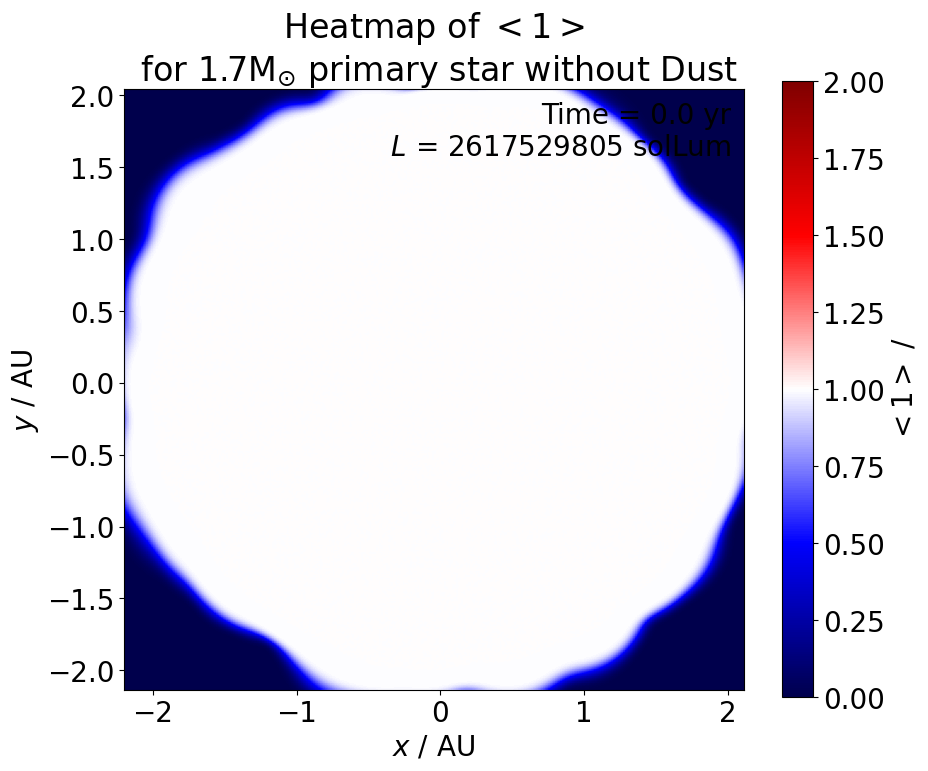

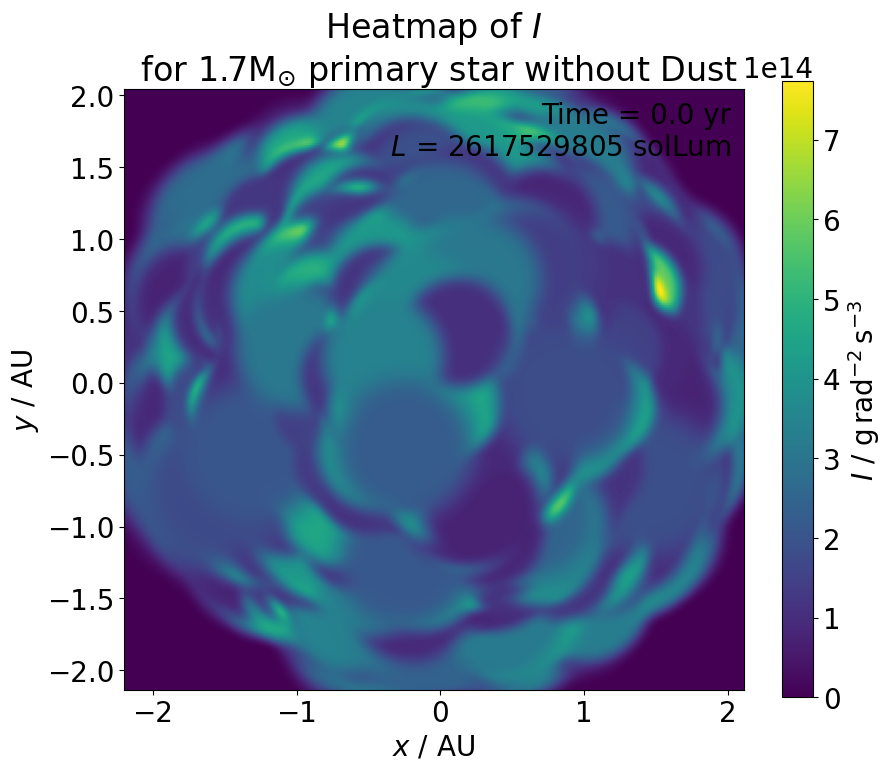

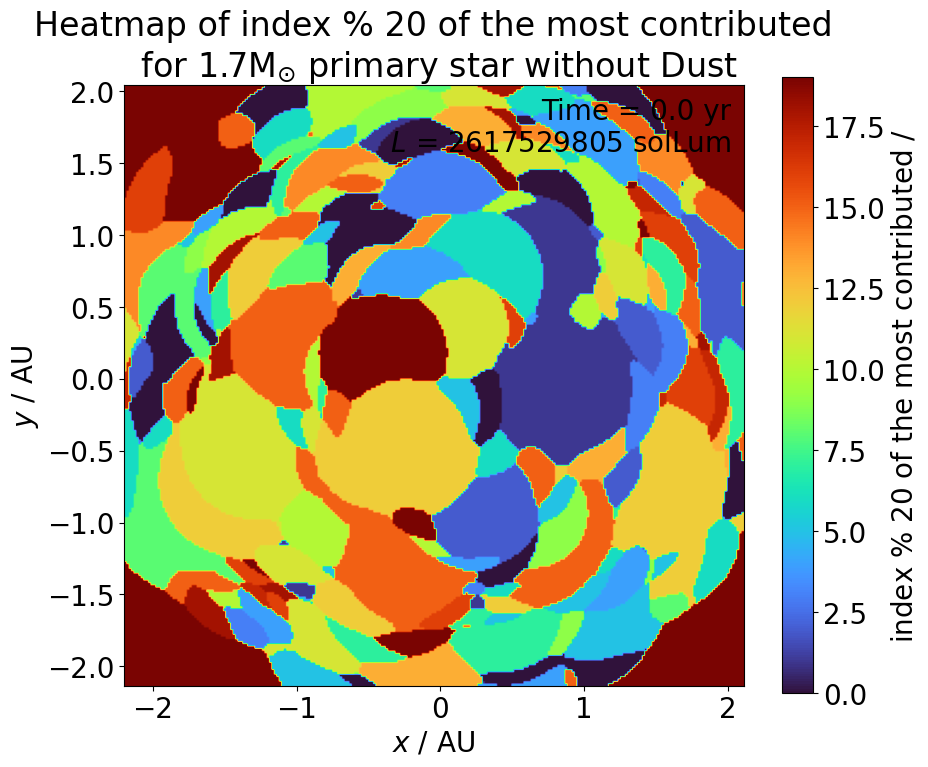

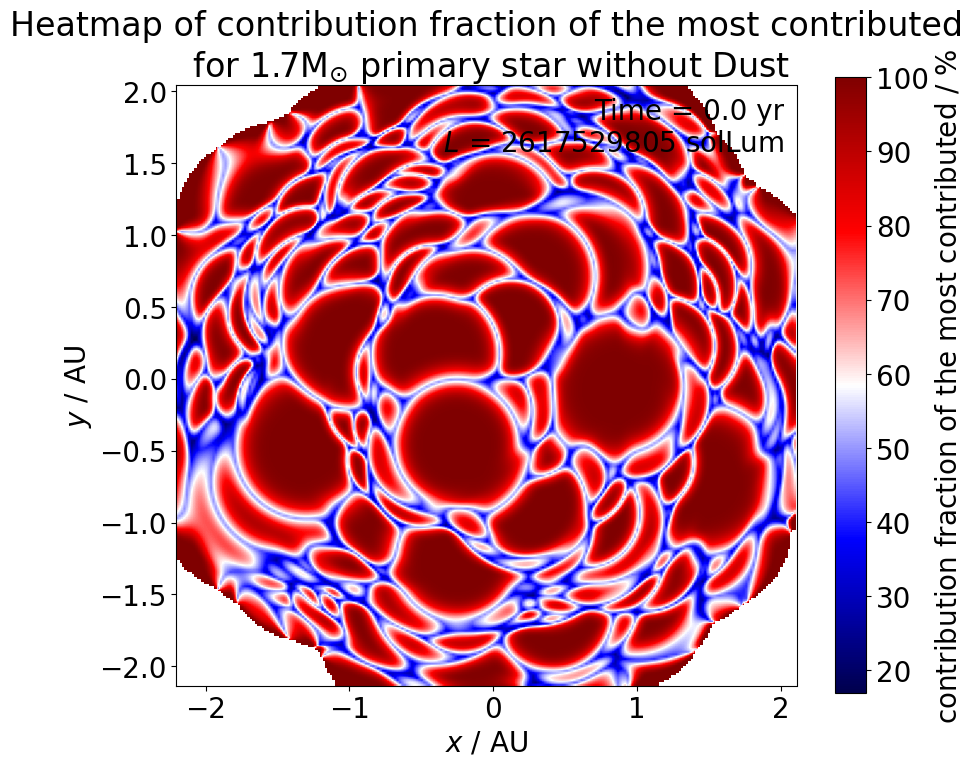

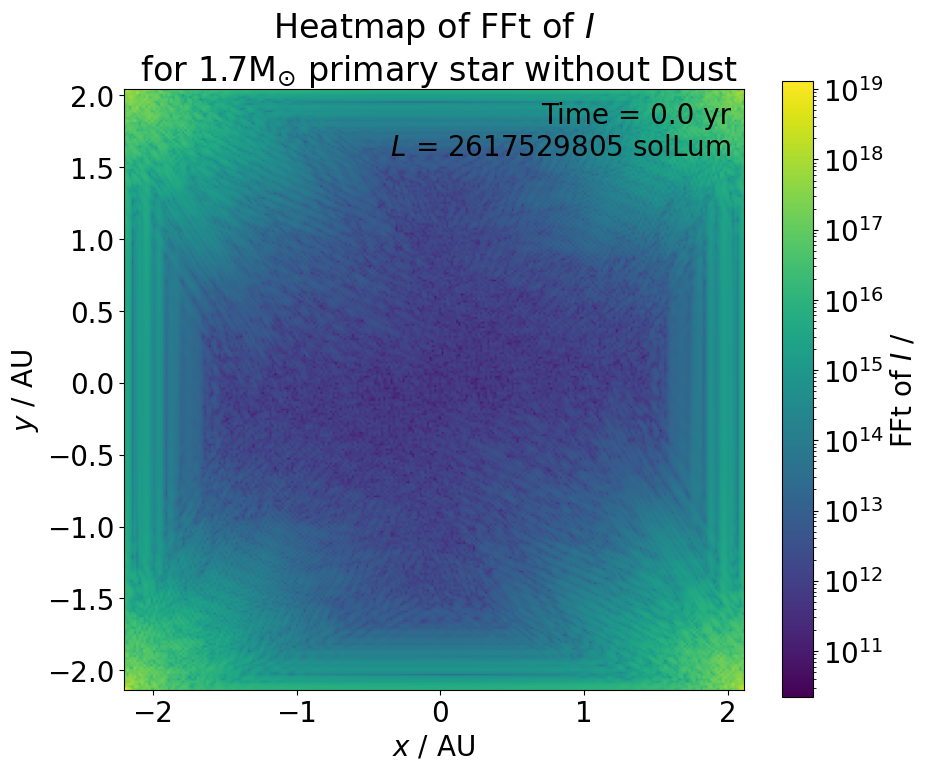

In [13]:
# plotting
plt.close('all')
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, ones, data_label="$<1>$", xyzs=xyzs, save_label=f"ones",
    job_profile=job_profile, file_index=file_index, cmap='seismic',
    norm=mpl.colors.Normalize(vmin=0., vmax = 2.),
    notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, rads, data_label="$I$", xyzs=xyzs, save_label=f"I",
    job_profile=job_profile, file_index=file_index,
    #norm=mpl.colors.Normalize(vmin=(0. if do_debug else None), vmax = (1. if do_debug else None)),
    notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, inds%20, data_label="index % 20 of the most contributed", xyzs=xyzs, save_label=f"dinds",
    job_profile=job_profile, file_index=file_index, cmap='turbo', notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, contr, data_label="contribution fraction of the most contributed", xyzs=xyzs, save_label=f"contr",
    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, np.abs(anses_fft), data_label="FFt of $I$", xyzs=xyzs, save_label=f"I-fft",
    norm=mpl.colors.LogNorm(),
    job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir)

    # do integration
    python_time_start = datetime.utcnow()
    print(f"Start: {python_time_start.isoformat()}")
    
    ans = integrate_along_ray_gridxy_err_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, verbose=99)
    rads, errs = ans
    rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
    errs = (errs * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
    lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
    lum_err =  ((4 * pi * units.sr) * (errs * areas_u)).sum().to(units.solLum)
    print(lum, lum_err)
    
    python_time_ended = datetime.utcnow()
    python_time__used  = python_time_ended - python_time_start
    print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}")

### Running all files

In [35]:
# inputs
file_indexes = np.concatenate((np.arange(0, 2000+1, 100), [4800, 6400, 8000, 17600]))
xyzs_list  = ['xyz', 'xzy']
#job_nickname= '2md'
#file_index  = 0
#xyzs = 'xyz'
no_xy=(256, 256)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
output_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
verbose_loop = 0


# init combined data
comb = {}

for job_nickname in ['2md',]: #['2md', '4md']:
    comb[job_nickname] = {
        xyzs: {
            'times_yr' : [],
            'lums_Lsun': [],
            } for xyzs in xyzs_list
        }
        
    for file_index in file_indexes:
        # init
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        params      = job_profile['params']
        eos_opacity = EoS_MESA_opacity(params, settings)
        mpdf = mpdf_read(job_name, file_index, eos_opacity, reset_xyz_by='R1', verbose=1)
        mpdf.calc_sdf_params(['R1'])
        sdf  = mpdf.data['gas']
        srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 / pi
        sdf['srcfunc'] = srcfuncs
        for xyzs in xyzs_list:
            xyzs_names_list = [x for x in xyzs]

            
            # record time used
            python_time_start = datetime.utcnow()
            print(f"Start: {python_time_start.isoformat()}")
            print(f"\tWorking on {job_nickname}_{file_index:05d}_{xyzs}...")

            
            # get rays
            rays, areas, dXs = get_xy_grids_of_rays(
                sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False, xyzs_names_list=xyzs_names_list)
            pts    = np.array(sdf[xyzs_names_list])
            hs     = np.array(sdf[ 'h' ])    # npart-shaped array
            kernel = sdf.kernel
            kernel_rad = float(kernel.get_radius())
            col_kernel = kernel.get_column_kernel_func(samples=1000)
            
            rays_u = (rays * mpdf.units['dist']).to(units.au)
            areas_u = (areas * mpdf.units['dist']**2).to(units.au**2)

            
            # do integration without error estimation
            ans = integrate_along_ray_gridxy_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, verbose=99)
            rads, inds, contr, pts_order_used = ans
            rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
            inds *= units.dimensionless_unscaled
            contr = 100 * contr * units.percent
            lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
            anses_fft = fft.fft2(rads.reshape(no_xy).value)
        
            # save interm data
            data = {}
            data['lum'  ] = lum
            data['rays' ] = rays_u[:, 0, :2]
            data['ray_unit_vec'] = get_ray_unit_vec(rays_u[0].value)
            data['area_per_ray'] = areas_u[0] #areas_u
            data['rads' ] = rads
            data['time' ] = mpdf.get_time()
            data['mpdf_params'] = mpdf.params
            
            with open(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{xyzs}.{no_xy_txt}.json", 'w') as f:
                mupl.json_dump(data, f, metadata)

            comb[job_nickname][xyzs]['times_yr' ].append(data['time'].to_value(units.yr))
            comb[job_nickname][xyzs]['lums_Lsun'].append(data['lum' ].to_value(units.Lsun))

            
            # plotting
            plt.close('all')
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, rads, data_label="$I$", xyzs=xyzs, save_label=f"I",
                job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir, verbose=verbose_loop)
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, inds%20, data_label="index % 20 of the most contributed", xyzs=xyzs, save_label=f"dinds",
                job_profile=job_profile, file_index=file_index, cmap='turbo', notes=data, output_dir=output_dir, verbose=verbose_loop)
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, contr, data_label="contribution fraction of the most contributed", xyzs=xyzs, save_label=f"contr",
                job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data, output_dir=output_dir, verbose=verbose_loop)
            #fig, ax, outfilenames = plot_imshow(
            #    no_xy, rays_u, np.abs(anses_fft), data_label="FFt of $I$", xyzs=xyzs, save_label=f"I-fft",
            #    norm=mpl.colors.LogNorm(),
            #    job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir, verbose=verbose_loop)


            # record time used
            python_time_ended = datetime.utcnow()
            python_time__used  = python_time_ended - python_time_start
            print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}\n")
            

plt.close('all')
with open(f"{interm_dir}lcgen.{no_xy_txt}.json", 'w') as f:
    mupl.json_dump(comb, f, metadata)

    Note: Density column rho already exist in self.time = 0.0.
Start: 2024-04-04T01:28:24.917374
	Working on 2md_00000_xyz...
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1858 particles actually participated calculation (0.13% of all particles, average 0.02 per ray.)
Ended: 2024-04-04T01:29:05.232427
Time Used: 0:00:40.315053

Start: 2024-04-04T01:29:05.232551
	Working on 2md_00000_xzy...
    Debug  :    integrate_along_ray_gridxy_err_ind():
	1867 particles actually participated calculation (0.13% of all particles, average 0.02 per ray.)
Ended: 2024-04-04T01:29:46.810683
Time Used: 0:00:41.578132

    Note: Density column rho already exist in self.time = 5000.0.
Start: 2024-04-04T01:29:48.431293
	Working on 2md_00100_xyz...
    Debug  :    integrate_along_ray_gridxy_err_ind():
	2138 particles actually participated calculation (0.15% of all particles, average 0.03 per ray.)
Ended: 2024-04-04T01:30:39.305732
Time Used: 0:00:50.874439

Start: 2024-04-04T01:30:39.305843
	Working 

*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_2md_256x256.pdf.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_2md_256x256.png.


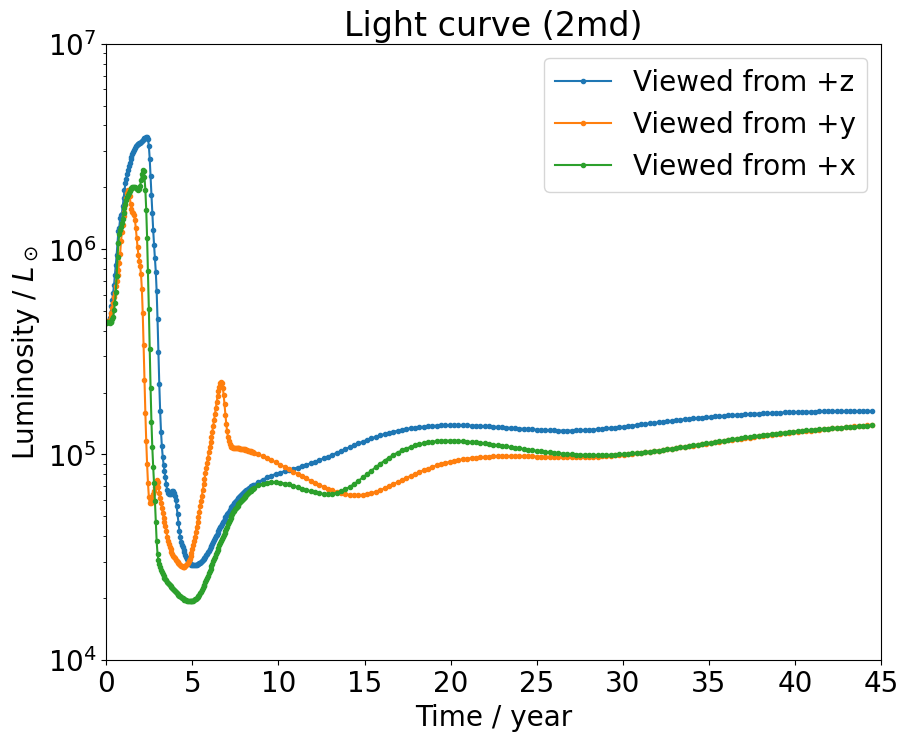

In [28]:
job_nickname='2md'
if False:
    comb = combs[no_xy_txt]
    xyzs_list = comb[job_nickname].keys()
    job_profile = JOB_PROFILES_DICT[job_nickname]
fig, ax = plt.subplots(figsize=(10, 8))
for xyzs in xyzs_list:
    ax.semilogy(comb[job_nickname][xyzs]['times_yr'], comb[job_nickname][xyzs]['lums_Lsun'], '.-', label=f"Viewed from +{xyzs[2]}")
ax.legend()
ax.set_xlabel('Time / year')
ax.set_ylabel('Luminosity / $L_\\odot$')
ax.set_xlim(0., 45.)
ax.set_ylim(1e4, 1e7)
outfilename_noext = f"{output_dir}LC_{job_profile['nickname']}_{no_xy_txt}"

# write pdf
#ax.set_title(f"1.7 $M_\\odot$")
outfilename = f"{outfilename_noext}.pdf"
fig.savefig(outfilename)
if is_verbose(verbose, 'note'):
    say('note', None, verbose, f"Fig saved to {outfilename}.")

# write png (with plot title)
ax.set_title(f"Light curve ({job_nickname})")
outfilename = f"{outfilename_noext}.png"
fig.savefig(outfilename)
if is_verbose(verbose, 'note'):
    say('note', None, verbose, f"Fig saved to {outfilename}.")

### Reading existing intermediate files

*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_dusty_256x256.pdf.
*   Note   :    run_ast_nodes() ==> run_code() ==> <module>():
	Fig saved to ../fig/20240222_LCGen/LC_dusty_256x256.png.


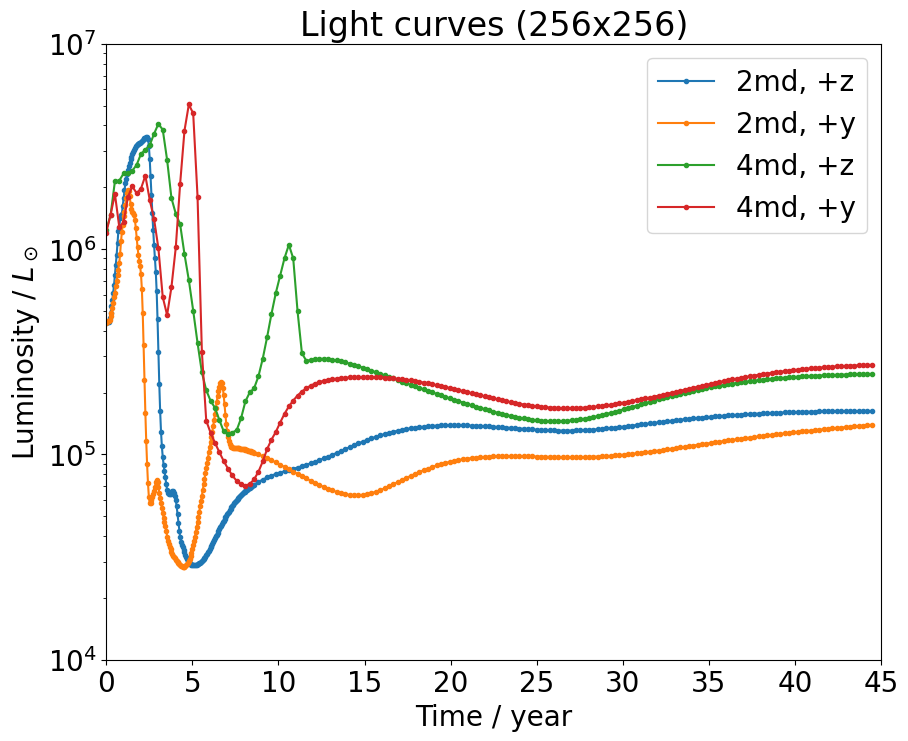

In [16]:
output_dir = f'../fig/20240222_LCGen/'
do_write = True


combs = {}

for rays_res in [256]: #[16, 64, 256]:
    no_xy = (rays_res, rays_res)
    no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
    with open(f"{interm_dir}lcgen.{no_xy_txt}.json", 'r') as f:
        combs[no_xy_txt] = mupl.json_load(f, metadata)


for no_xy_txt in combs.keys():
    comb = combs[no_xy_txt]
    fig, ax = plt.subplots(figsize=(10, 8))
    for job_nickname in ['2md', '4md']: #comb.keys(): #['2md']: #['2md', '4md']: #
        for xyzs in ['xyz', 'xzy']: #comb[job_nickname].keys(): #['xzy']: #
            ax.semilogy(
                comb[job_nickname][xyzs]['times_yr'],
                comb[job_nickname][xyzs]['lums_Lsun'],
                '.-',
                label=f"{job_nickname}, +{xyzs[2]}")
    ax.legend()
    ax.set_xlabel('Time / year')
    ax.set_ylabel('Luminosity / $L_\\odot$')
    ax.set_xlim(0., 45.)
    ax.set_ylim(1e4, 1e7) #(1e4, 1e7) #(1e4, 5e8) #
    outfilename_noext = f"{output_dir}LC_dusty_{no_xy_txt}"
    
    # write pdf
    if do_write:
        outfilename = f"{outfilename_noext}.pdf"
        fig.savefig(outfilename)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Fig saved to {outfilename}.")
    
    # write png (with plot title)
    ax.set_title(f"Light curves ({no_xy_txt})")
    if do_write:
        outfilename = f"{outfilename_noext}.png"
        fig.savefig(outfilename)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Fig saved to {outfilename}.")

In [33]:
from clmuphantomlib.units_util import DEFAULT_UNITS
(DEFAULT_UNITS['time'] * 280000).to(units.yr)

<Quantity 14.1328989 yr>

### Timeit

**  Warning:    integrate_along_ray_grid():
	This function is a work in progress-
	It is highly likely to be removed and integrated into integrate_along_ray_grid() in the future,and even if not, the input & output format may still change in the future,
	especially to output uncertainty estimation as well!


array([0., 0., 0., ..., 0., 0., 0.])

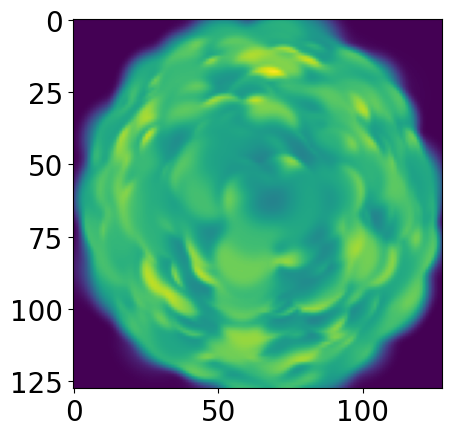

In [16]:
xyzs = 'yzx'
xyzs_names_list = [x for x in xyzs]
ans = integrate_along_ray_gridxy(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list)
plt.close('all')
plt.imshow(ans.reshape(no_xy))
plt.savefig(f"{output_dir}/heat_I_{job_nickname}_{mpdf.file_index}_{xyzs}.png")
ans

In [50]:
%timeit integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)

3.8 s ± 391 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%timeit integrate_along_ray_gridxy(sdf, srcfuncs, rays, verbose=0)

38.6 s ± 1.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit [integrate_along_ray(sdf, ray, srcfuncs)[4] for ray in rays]

3.46 s ± 52.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Analyzing error for tau

In [21]:
# integrating for column kernel
kernel = sdf.kernel
ndim   = 3
q_xy   = 1.
w_col  = kernel.get_column_kernel_func(1000)

q_xy   = 0.

@jit(nopython=True, fastmath=True)
def get_q(*q_is):
    ans = 0
    for q_i in q_is:
        ans += q_i**2
    return ans**0.5


def get_w_q(q_z, q_xy, w, ndim):
    return kernel.w(get_q(q_xy, q_z), ndim)

def my_col(q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    return integrate.quad(lambda q_z: w(get_q(q_xy, q_z), ndim), -w_rad, w_rad)
    
#my_col(q_xy, kernel=kernel, ndim=ndim),  w_col(q_xy, ndim)

In [34]:


def get_tau_for_single_particle(kappa_m_div_h2:float, q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    w_col = kernel.get_column_kernel_func(1000)

    return -np.log(integrate.quad(
        lambda q_z: np.exp(-kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -w_rad, q_z
        )[0]) * w(get_q(q_xy, q_z), ndim),
        -w_rad, w_rad, 
    )[0] / w_col(q_xy, ndim))

kappa_m_div_h2, q_xy = 100., 1.5
dtau  = kappa_m_div_h2*w_col(q_xy, ndim)
w_col = kernel.get_column_kernel_func(1000)
term = 1-np.exp(-dtau)
tau = get_tau_for_single_particle(kappa_m_div_h2=kappa_m_div_h2, q_xy=q_xy, kernel=kernel, ndim=ndim)
print(f"{tau=}", f"{dtau=}", f"frac= {(tau/dtau)*100:.2f}%", '', sep='\n')
print(
    f"{np.exp(-tau    )*term=}",
    f"{np.exp(-tau    )*dtau=}",
    f"{np.exp(-0.     )*term=}",
    f"{np.exp(-dtau/2.)*term=}",
    f"{np.exp(-dtau   )*term=}",
    sep='\n')

tau=0.5181579431705783
dtau=1.144245115276666
frac= 45.28%

np.exp(-tau    )*term=0.40593408430450867
np.exp(-tau    )*dtau=0.6815314971276399
np.exp(-0.     )*term=0.6815357691425217
np.exp(-dtau/2.)*term=0.3846085939325134
np.exp(-dtau   )*term=0.21704476452183305


In [192]:
w_col

CPUDispatcher(<function BaseKernel.get_column_kernel_func.<locals>.func at 0x146fe5034e00>)

In [191]:
kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -2., 1.)[0]

0.045134625081233753

In [70]:
help(kernel.get_column_kernel_func)

Help on method get_column_kernel_func in module sarracen.kernels.base_kernel:

get_column_kernel_func(samples) method of sarracen.kernels.cubic_spline.CubicSplineKernel instance
    Generate a numba-accelerated column kernel function.
    
    Creates a numba-accelerated function for column kernel weights. This function
    can be utilized similarly to kernel.w.
    
    Parameters
    ----------
    samples: int
        Number of sample points to calculate when approximating the kernel.
    
    Returns
    -------
    A numba-accelerated weight function.



### In Writing

#### Getting LC

In [9]:
do_extrap : bool = False
T_cond_oxy: units.Quantity = 1450 * units.K
kappa_gas : units.Quantity = 2e-4*(units.cm**2/units.g)
job_name    = '../dustystar/clmu_dustybase/relax'#job_profile['job_name']
file_index  = 0
params      = JOB_PROFILES_DICT['2md']['params'] #job_profile['params']


mpdf = mupl.MyPhantomDataFrames()
mpdf.read(job_name, file_index, reset_xyz_by='CoM', calc_params=['vr', 'R1'], verbose=verbose)
sdf  = mpdf.data['gas']
eos = mupl.get_eos(ieos=10, params=params, settings=settings)
eos_opacity = EoS_MESA_opacity(params, settings)
sdf['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
del sdf['Tdust']
kappa_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=do_extrap)
#mpdf.data['gas']['kappa'] = np.where(
#    mpdf.data['gas']['T'] < T_cond_oxy,
#    kappa_gas.to_value( mpdf.units['opacity']),
#    kappa_mesa.to_value(mpdf.units['opacity']),
#)
mpdf.data['gas']['kappa'] = kappa_mesa.to_value(mpdf.units['opacity'])

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../dustystar/clmu_dustybase/relax_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([-3.80369850e-16  3.71216564e-17 -6.51535922e-19])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [-2.44519036e-16  2.48560465e-17 -4.36257665e-19]


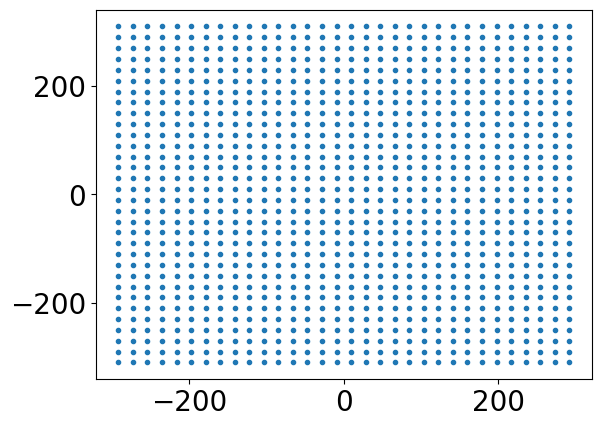

In [17]:
# testing ray loc distribution
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=(32, 32), frac_contained=100., use_adaptive_grid=False)
plt.plot(rays[:, 0, 0], rays[:, 0, 1], '.')

In [19]:
hs = dats
hs

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
#no_xy=(17, 17)
no_xy=(32, 32)
srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi #/ (4 * pi)
#srcfuncs = np.array(sdf['h'])


rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

3.11e+04 solLum


<Quantity 31063.67752247 solLum>

(array([ 118.,  296., 3210., 3684., 1236.,  842.,  346.,  124.,  100.,
          44.]),
 array([3.33697822, 3.60437679, 3.87177536, 4.13917393, 4.4065725 ,
        4.67397107, 4.94136964, 5.20876821, 5.47616678, 5.74356535,
        6.01096392]),
 <BarContainer object of 10 artists>)

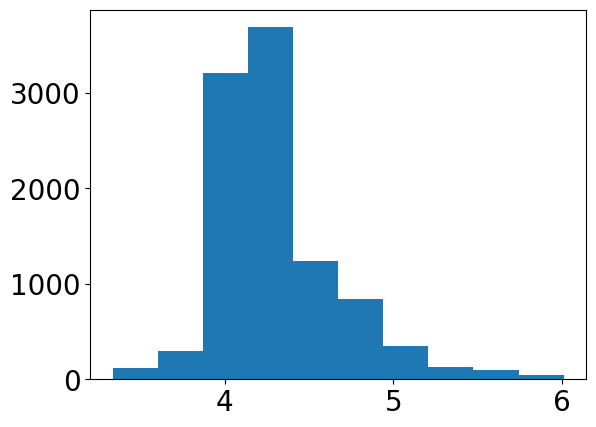

In [367]:
plt.hist(np.log10(mpdf.get_val('T').value))

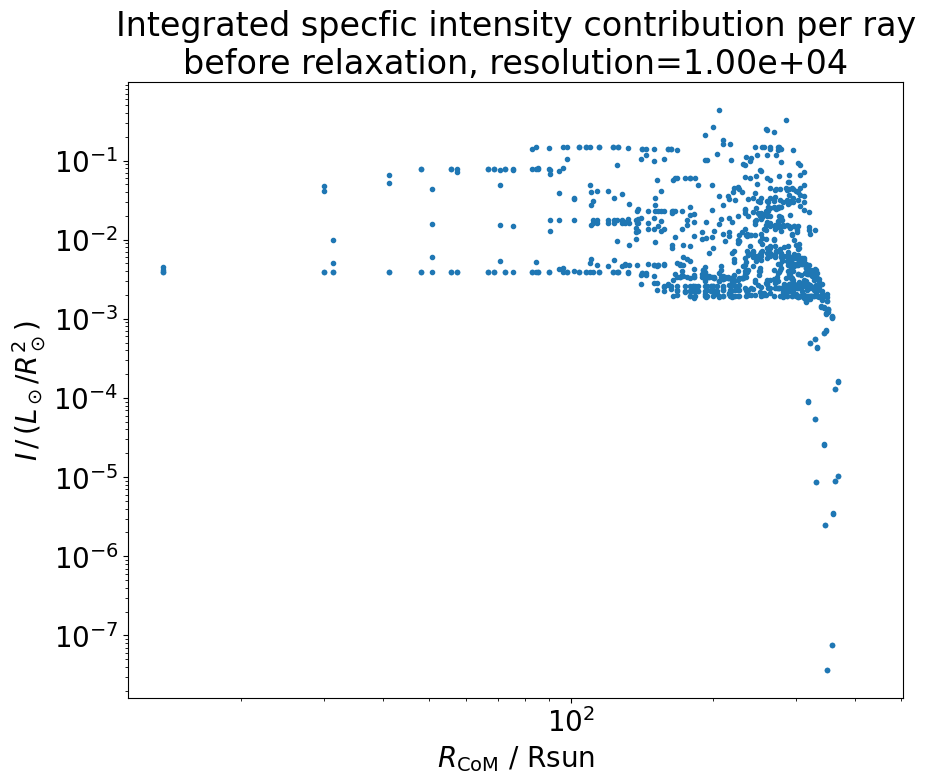

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.to_value(units.Lsun) / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
#ax.set_ylabel('$\\triangle L$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_relax_res{mpdf.params['nparttot']:.2e}.png")

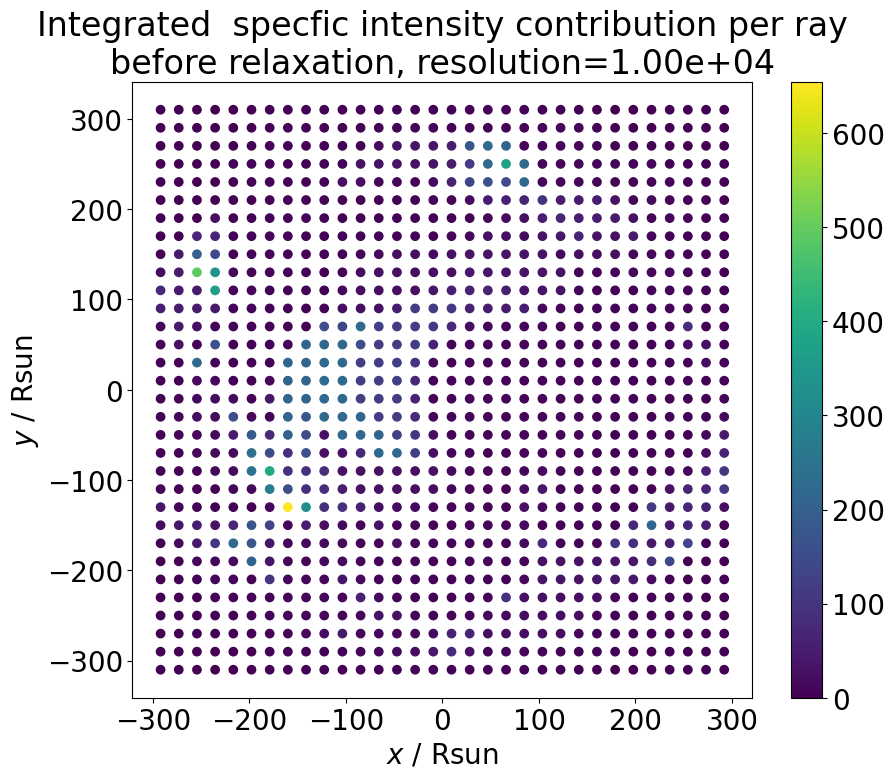

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=np.array(lums).reshape(no_xy))
fig.colorbar(s, label='')# {I / (4 \pi L_\\odot / R_\\odot^2)}$')
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Rsun')
ax.set_title(f"Integrated  specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dlum_relax_res{mpdf.params['nparttot']:.2e}.png")

.

#### Trying the same thing with after-relaxed higher resolution model

.

In [23]:
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
print(f"{mpdf.get_time() = }")

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = 0.0.
mpdf.get_time() = <Quantity 0. yr>


In [29]:
mpdf.data['gas']['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
mpdf.data['gas'][['Tdust', 'temperature', 'T']]

Tdust  temperature            T
0         905.561625   905.561625   905.129634
1        1115.608310  1115.608310  1115.695717
2         646.971790   646.971790   647.096207
3         558.378969   558.378969   558.402400
4        1069.234617  1069.234617  1069.029598
...              ...          ...          ...
1372083   391.453956   391.453956   391.395060
1372084   793.322333   793.322333   793.402575
1372085   890.293809   890.293809   890.389795
1372086  1044.076902  1044.076902  1044.605001
1372087   842.491614   842.491614   842.476935

[1372088 rows x 3 columns]

In [24]:
#no_xy=(17, 17)
no_xy=(32, 32)

srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

4.37e+05 solLum


<Quantity 436826.62309983 solLum>

In [26]:
srcfuncs = np.array(sdf['h'])
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
hs   = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
hs  *= units.Rsun
hs

<Quantity [0., 0., 0., ..., 0., 0., 0.] solRad>

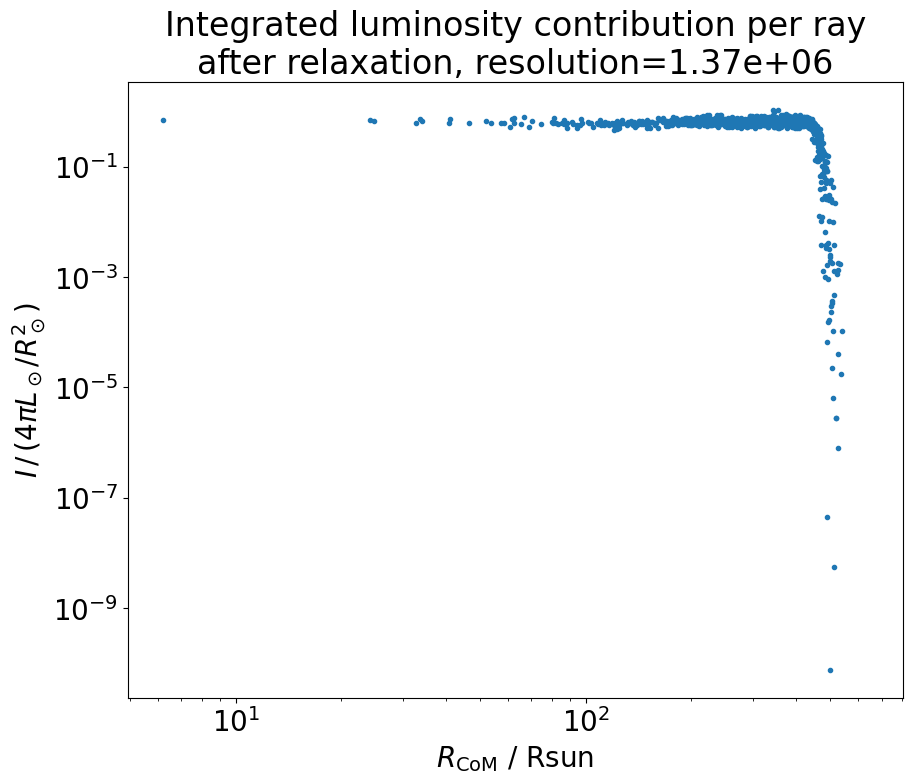

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.value / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
ax.set_title(f"Integrated luminosity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_light_res{mpdf.params['nparttot']:.2e}.png")

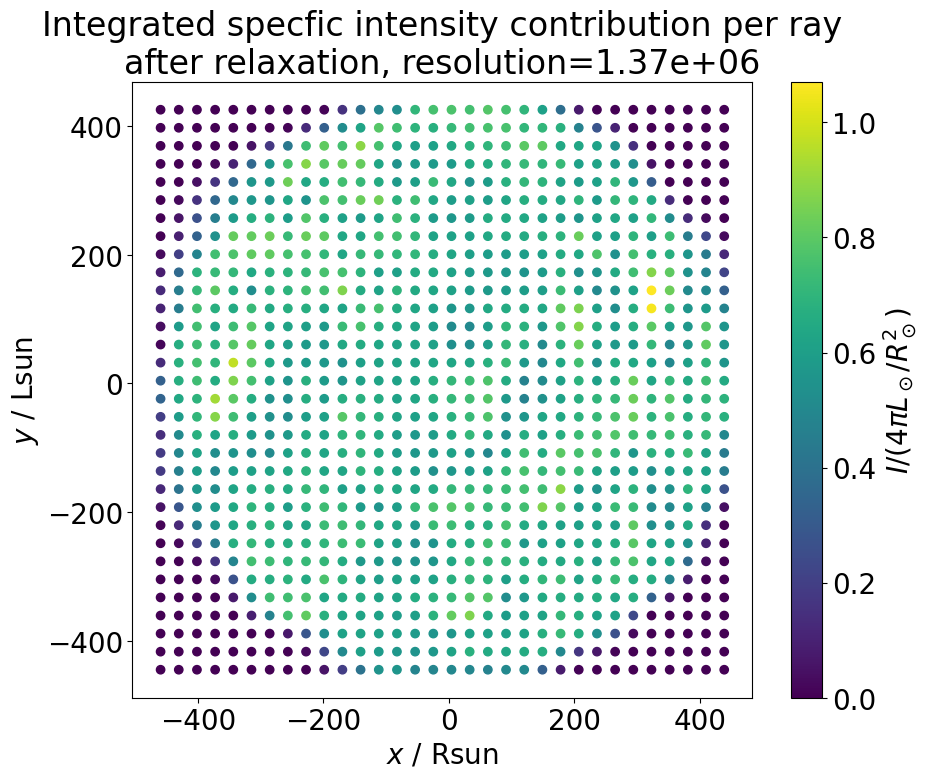

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

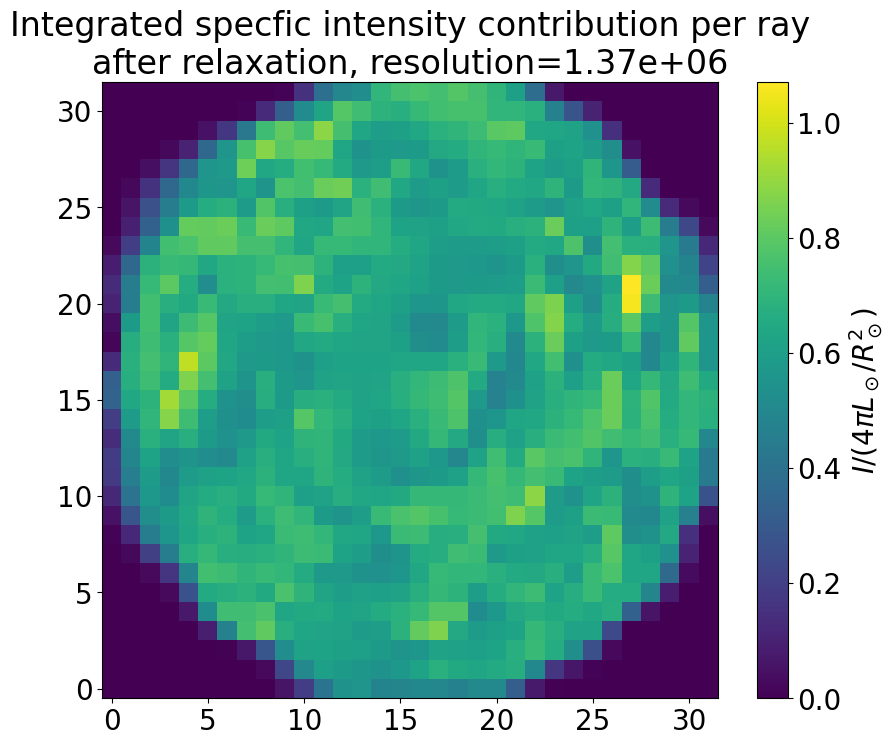

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(lums / areas).reshape(no_xy), origin='lower')
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
#ax.set_xlabel('$x$')# / Rsun')
#ax.set_ylabel('$y$')# / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

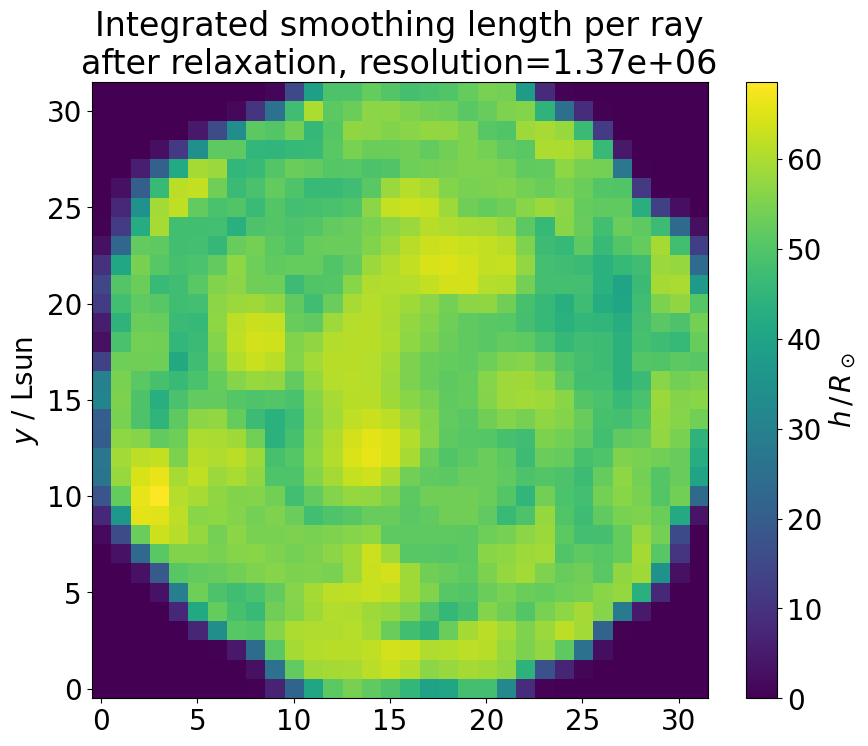

In [49]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(hs).reshape(no_xy), origin='lower')
fig.colorbar(s, label='$h \\, / \\, R_\\odot$') #\\log_{10} 
#ax.set_xlabel('$x$ / Rsun')
#ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated smoothing length per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

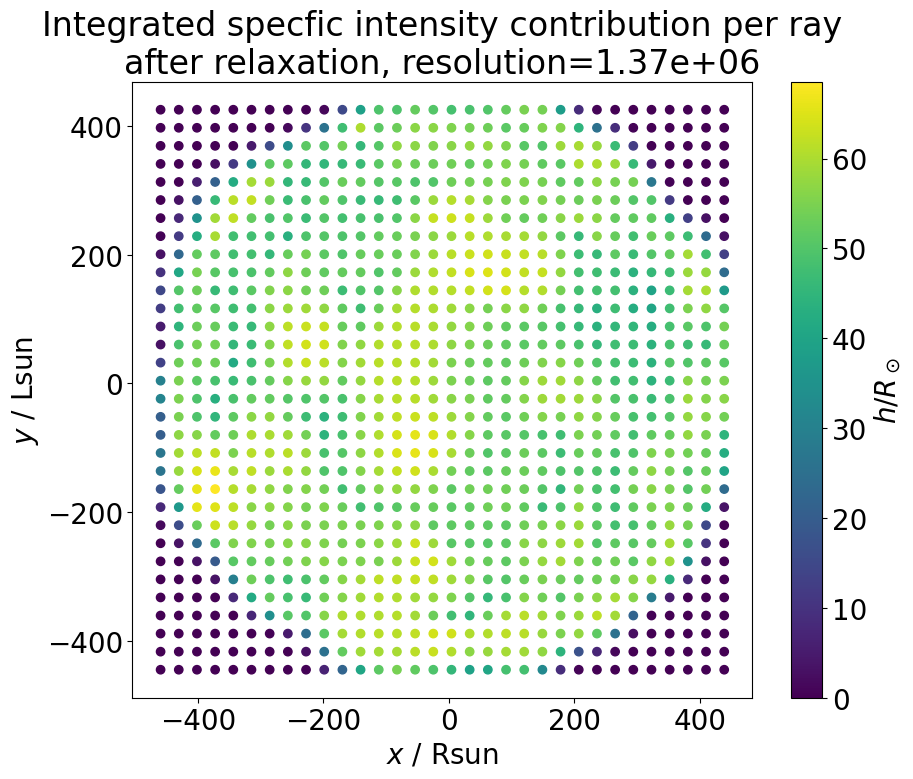

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(hs).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${h / R_\\odot}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

In [40]:
help(ax.imshow)

Help on method imshow in module matplotlib.axes._axes:

imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs) method of matplotlib.axes._axes.Axes instance
    Display data as an image, i.e., on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. For displaying a grayscale
    image, set up the colormapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    The number of pixels used to render an image is set by the Axes size
    and the figure *dpi*. This can lead to aliasing artifacts when
    the image is resampled, because the displayed image size will usually
    not match the size of *X* (see
    :doc:`/gallery/images_contours_and_fields/image_antialiasing`).
    The resampling can be controlled vi

In [53]:
7534.8/10246.54

0.7353506647121857

In [ ]:
f"{lum:.2e}"

In [83]:
get_xy_grids_of_rays

<function __main__.get_xy_grids_of_rays(sdf: None | sarracen.sarracen_dataframe.SarracenDataFrame = None, dxs: None | tuple[float, float] = (None, None), no_xy: tuple[int, int] = (33, 33), orig_vec: numpy.ndarray = array([0., 0., 0.]), frac_contained: float = 99.73, verbose: int = 3) -> tuple[numpy.ndarray, numpy.ndarray]>

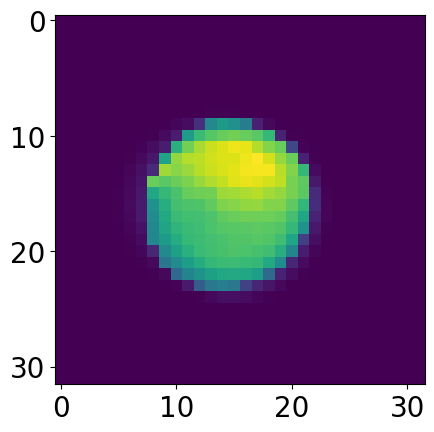

In [38]:
plt.imshow(np.array(lums).reshape(no_xy))

In [136]:
np.max(mpdf.data['gas']['h'])

93.82694

In [15]:
mpdf.data['gas']['u']

0       0.003596
1       0.003596
2       0.012142
3       0.012142
4       0.004077
          ...   
9995    0.003971
9996    0.004889
9997    0.004889
9998    0.008964
9999    0.008964
Name: u, Length: 10000, dtype: float64

## IGNORE BELOW
#### NOT YET FINISHED ADAPTING FROM THE OLD SCRIPTS

### Getting initial MESA profile vs relaxed phantom profile

In [129]:
def plot_stuff(stuff_dict: dict, x_name: str, y_name: str, mpdf, job_profile, xlim: tuple[float, float]=(1., 1.e3)):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.loglog(stuff_dict[x_name], stuff_dict[y_name], '.')
    ax.set_xlabel(f"{x_name} / {stuff_dict[x_name].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"{y_name} / {stuff_dict[y_name].unit.to_string('latex_inline')}")
    ax.text(
        0.98, 0.98, f"Time = {mpdf.get_time()}",
        ha = 'right', va = 'top', transform=ax.transAxes,
    )
    ax.set_title(f"scatter plot of all particles\n{job_profile['plot_title_suffix']}")
    ax.set_xlim(xlim)
    return fig, ax

In [130]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 #/ (4 * pi)

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
    Note: Density column rho already exist in self.time = 0.0.


In [131]:
# reading mesa data
mesa_data = np.loadtxt(
    '../dustystar/AGB_th.data', skiprows=6,
    usecols=(2, 3, 4, 9, 10, 11, 12, 19),
    dtype=[
        ('log10_R1', np.double),
        ('log10_T', np.double),
        ('log10_rho', np.double),
        ('R1_cm', np.double),
        ('mass_g', np.double),
        ('temp', np.double),
        ('rho', np.double),
        ('lum', np.double)]
)
stuff_mesa = {
    'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
    'T' : mesa_data['temp'] * units.K,
    'lum' : mesa_data['lum'] * units.Lsun,
    'rho' : mesa_data['rho'] * (units.g/units.cm**3)
}
del mesa_data 
stuff_mesa['L'    ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T']**4)).to(units.Lsun)
stuff_mesa['kappa'] = eos_opacity.get_kappa(rho=stuff_mesa['rho'], T=stuff_mesa['T'])
#stuff_mesa['wtf'  ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T'].value**2.5 * units.K**4)).to(units.Lsun)
# below should be one, but it is not. Not sure why
L_0 = stuff_mesa['lum'][0]
R_0 = stuff_mesa[ 'R1'][0]
stuff_mesa['factor'] = (stuff_mesa['R1'].cgs**2 * (
    R_0**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs
stuff_mesa['wtf'  ]  = (integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2)[::-1].cgs, stuff_mesa['R1'][::-1].cgs, initial=0
    )*units.cm**(-2))[::-1]
stuff_mesa['test' ]  = (stuff_mesa['R1'].cgs[0]**2 * (
    stuff_mesa['R1'].cgs**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs

In [132]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['rho'  ] = mpdf.get_val('rho').cgs

In [134]:
stuff_rad = stuff.copy()
stuff_rad_indices = ()

{'kappa': <Quantity [133.56917133, 133.57835947,  30.65612505, ..., 123.5633288 ,
            145.02782696, 145.43255533] cm2 / g>,
 'R1': <Quantity [117.41363041, 117.62030306,  39.48377157, ...,  79.99364505,
            214.41958202, 214.37990432] solRad>,
 'T': <Quantity [ 40397.57767182,  40412.32125512, 113056.64499532, ...,
             58413.96227326,  13905.68372774,  13901.40337589] K>,
 'L': <Quantity [3.30789724e+07, 3.32440138e+07, 2.29464398e+08, ...,
            6.71229932e+07, 1.54878794e+06, 1.54630943e+06] solLum>,
 'rho': <Quantity [2.24129369e-07, 2.24244666e-07, 1.65876494e-06, ...,
            5.49534716e-07, 1.60148092e-08, 1.60588815e-08] g / cm3>}

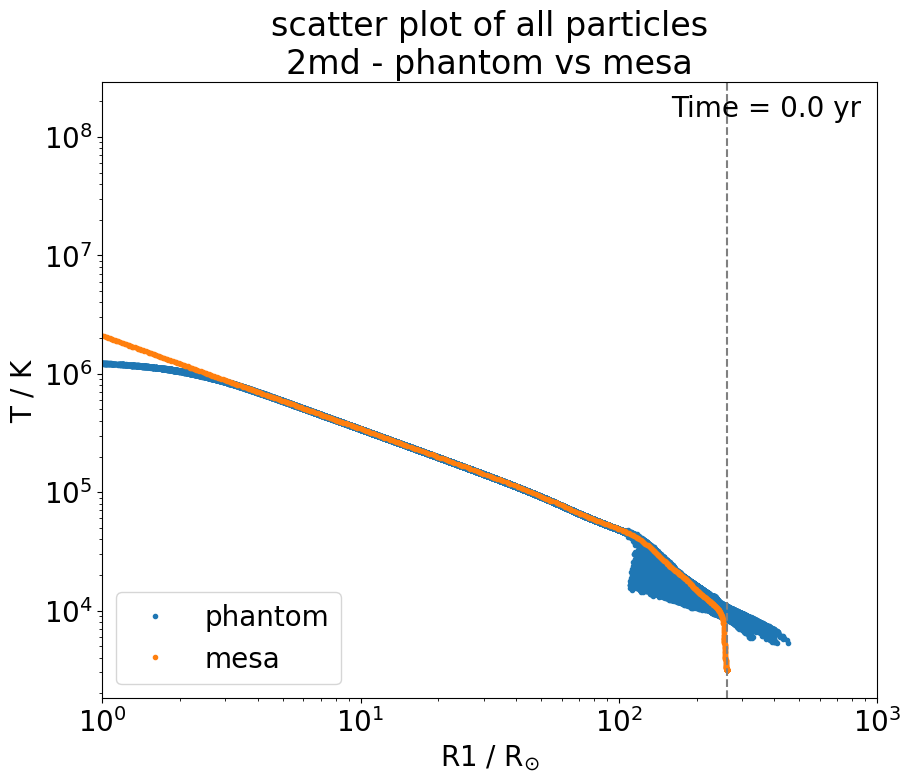

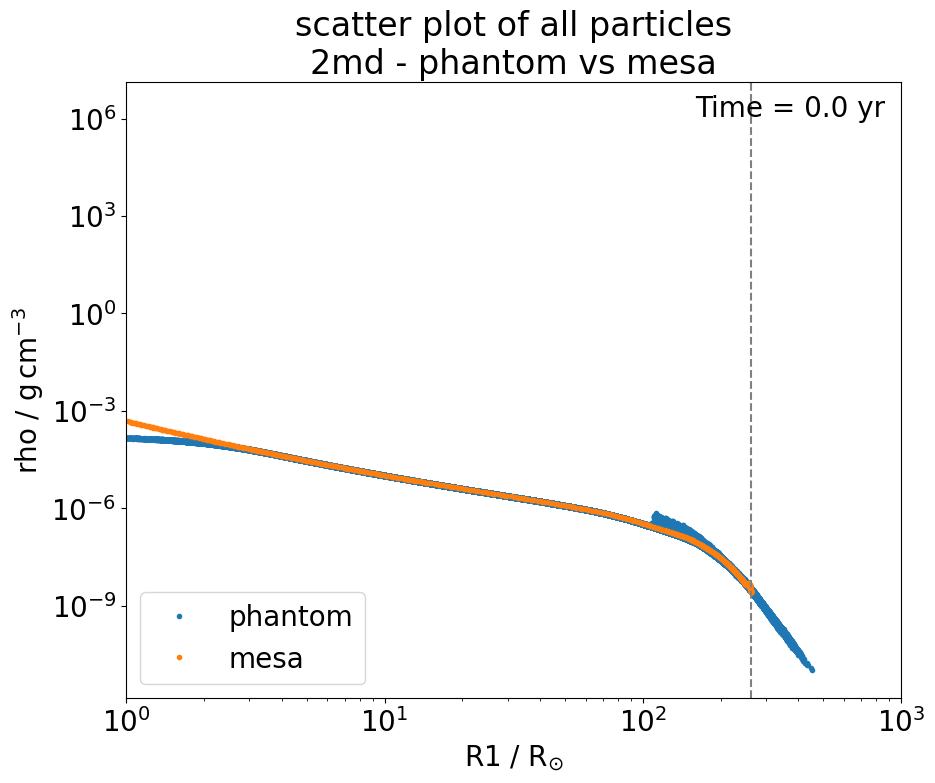

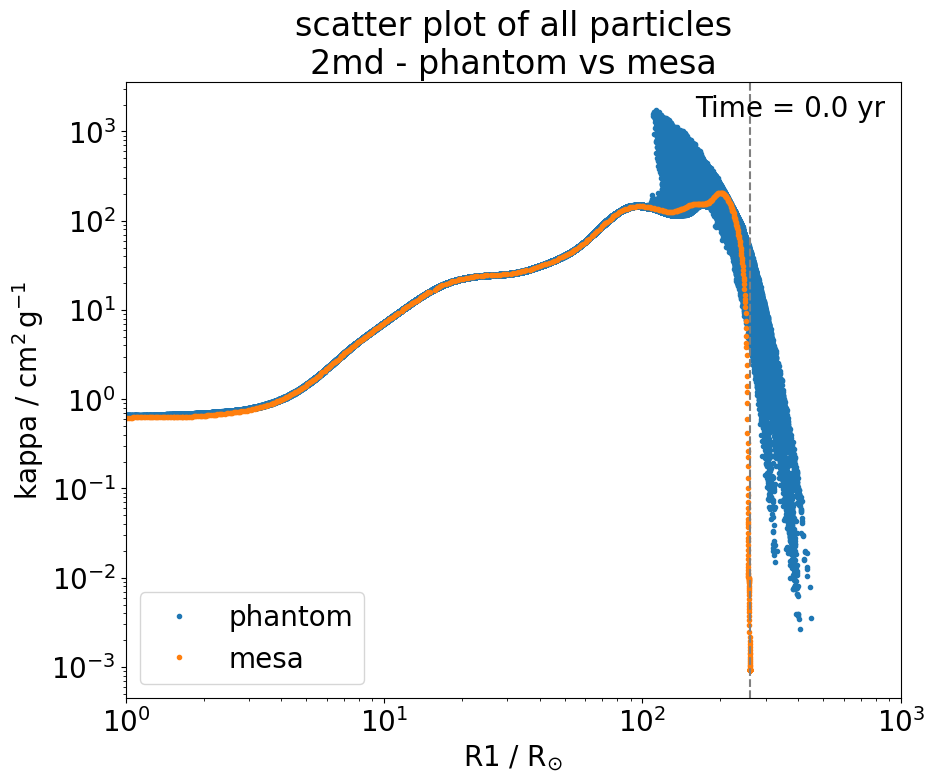

In [97]:
plt.close('all')
for what in ['T', 'rho', 'kappa']:
    fig, ax = plot_stuff(stuff, 'R1', what, mpdf, {'plot_title_suffix' : job_nickname + " - phantom vs mesa"})
    ax.loglog(stuff_mesa['R1'], stuff_mesa[what], '.', label='mesa')
    ax.axvline(x=stuff_mesa['R1'][0].value, color='grey', linestyle='dashed')
    ax.legend(['phantom', 'mesa'], loc='lower left')
    fig.savefig(f"{output_dir}/phantom-vs-mesa_2md_{what}-R1.png")
    plt.show(fig)

In [79]:
np.log(678e89)

211.44922056441047

In [88]:
%timeit np.log(123e34) - 211.44922056441047

645 ns ± 29 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [85]:
%timeit 123e34 / np.exp(211.44922056441047)

646 ns ± 44.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [10]:
(450*units.au).to_value(mpdf.units['dist'])

96729.71020188232

In [20]:
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

<Quantity 0.09406566 solMass>

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

In [10]:
mpdf.get_val('kappa').cgs

<Quantity [133.56917133, 133.57835947,  30.65612505, ..., 123.5633288 ,
           145.02782696, 145.43255533] cm2 / g>

In [9]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['wtf'  ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T'].value**2.5 * units.K**4)).to(units.Lsun)
stuff['rhokappa'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs
stuff['rhokappaR'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs * mpdf.get_val('R1').cgs

In [12]:
np.max(stuff['rhokappaR'] / (stuff['rhokappaR'] - 2) - 1)

<Quantity 5.93546797>

In [13]:
np.min(stuff['rhokappaR'] )

<Quantity 1.14535854>

In [94]:
(stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs

<Quantity [7.36338304e-39, 7.36338305e-39, 7.36338311e-39, ...,
           1.93680116e-10, 2.86581724e-10, 4.54900567e-10] 1 / cm3>

In [83]:
(L_0 / R_0**2).cgs

<Quantity 6.85653849e+10 g / s3>

(0.0, 2.0)

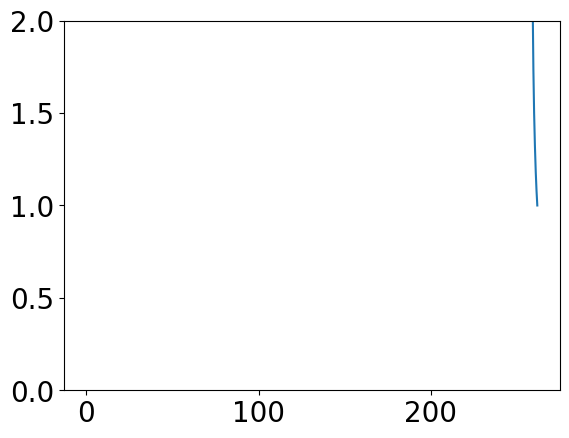

In [96]:
plt.plot(stuff_mesa['R1'], stuff_mesa['factor'])
plt.ylim(0., 2.)

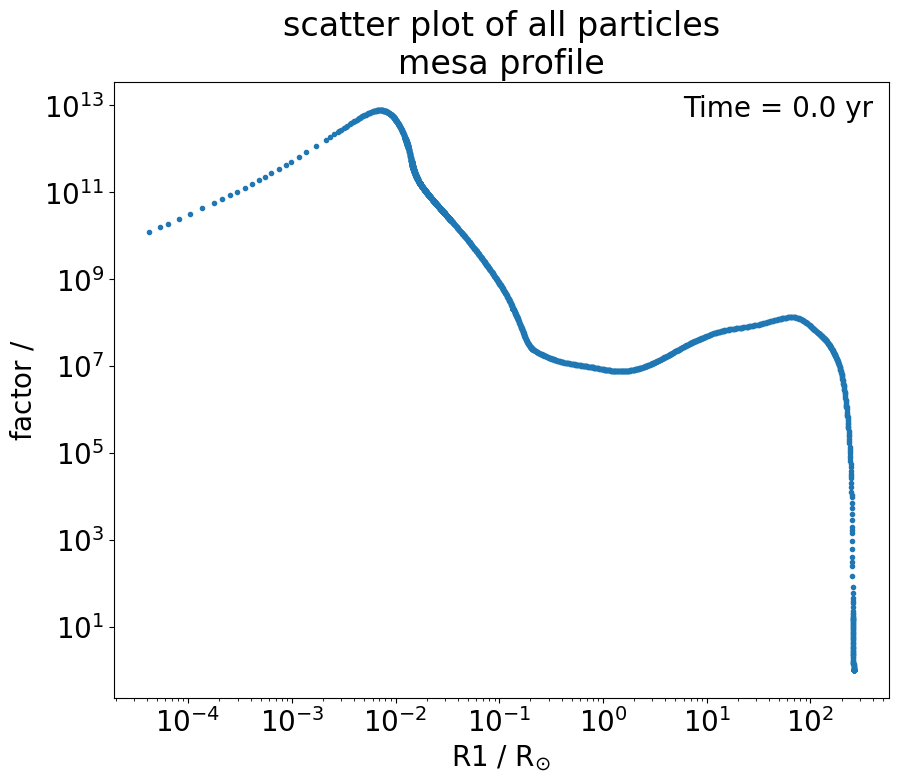

In [102]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'factor', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

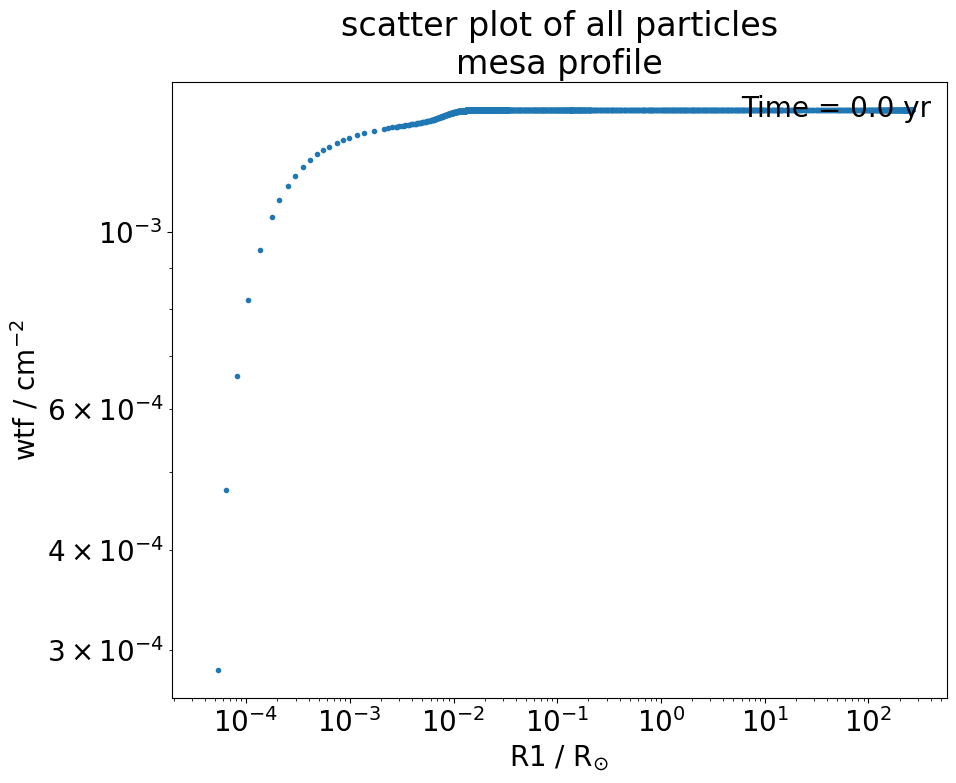

In [77]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'wtf', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

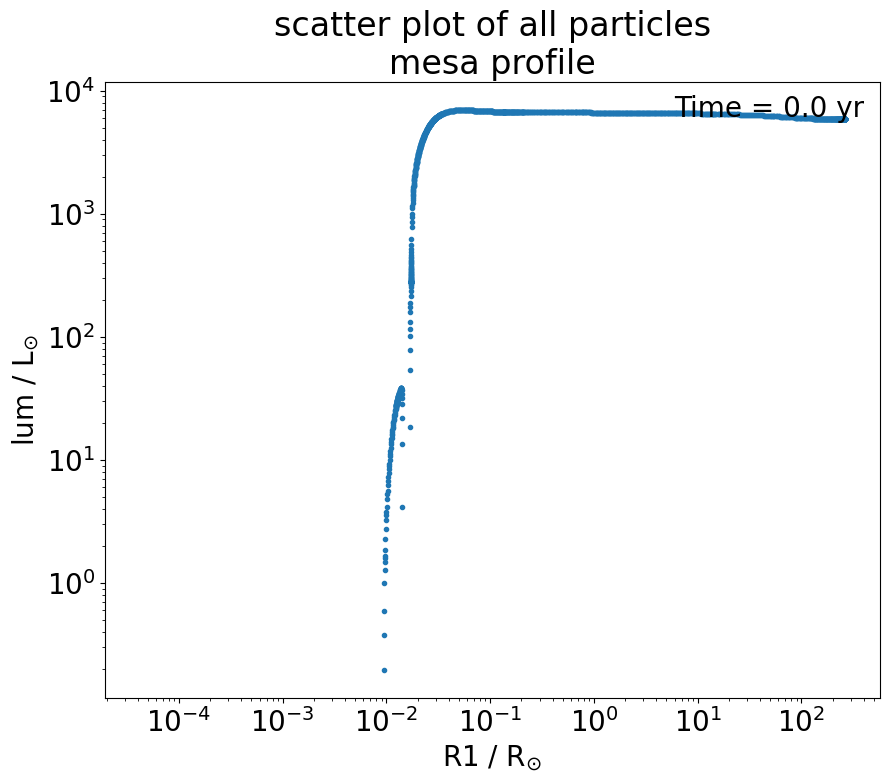

In [22]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'lum', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [23]:
stuff_mesa['T']

<Quantity [3.13480871e+03, 3.13480872e+03, 3.13480872e+03, ...,
           8.60392624e+07, 8.60381553e+07, 8.60371077e+07] K>

In [ ]:
eos_opacity.get_kappa(stuff_mesa)

In [24]:
stuff_mesa['lum'][:10]

<Quantity [5942.18103437, 5942.18103437, 5942.18103437, 5942.18103437,
           5942.18103437, 5942.18103437, 5942.18103437, 5942.18103437,
           5942.18103437, 5942.18103438] solLum>

In [22]:
stuff_mesa['L'][0], stuff_mesa['lum'][0]

(<Quantity 5963.57578799 solLum>, <Quantity 5942.18103437 solLum>)

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'T', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

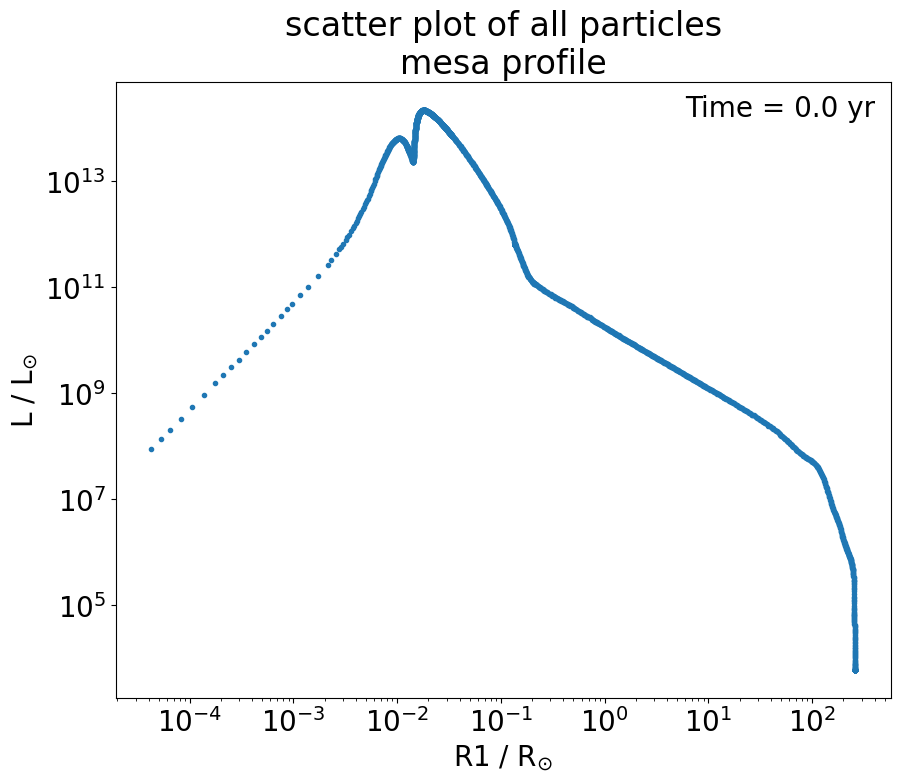

In [20]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'L', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [191]:
stuff_mesa['R1'][::100]

<Quantity [2.61808921e+02, 2.55975645e+02, 1.94075405e+02, 7.30456979e+01,
           1.04704689e+01, 2.71052753e+00, 7.73360559e-01, 1.88993556e-01,
           1.36619719e-01, 6.87743903e-02, 3.22256485e-02, 2.51569830e-02,
           2.00607213e-02, 1.71544759e-02, 1.59214561e-02, 1.47879525e-02,
           1.34108519e-02, 1.03266723e-02, 1.16591858e-03] solRad>

In [ ]:
# phantom plots

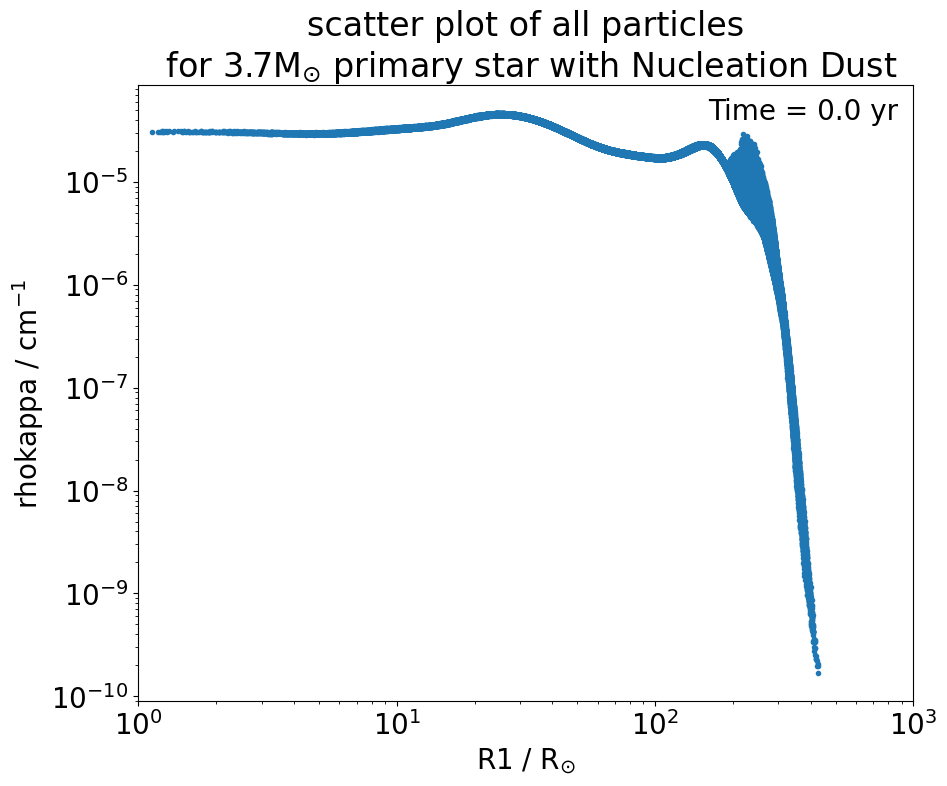

In [17]:
fig, ax = plot_stuff(stuff, 'R1', 'rhokappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

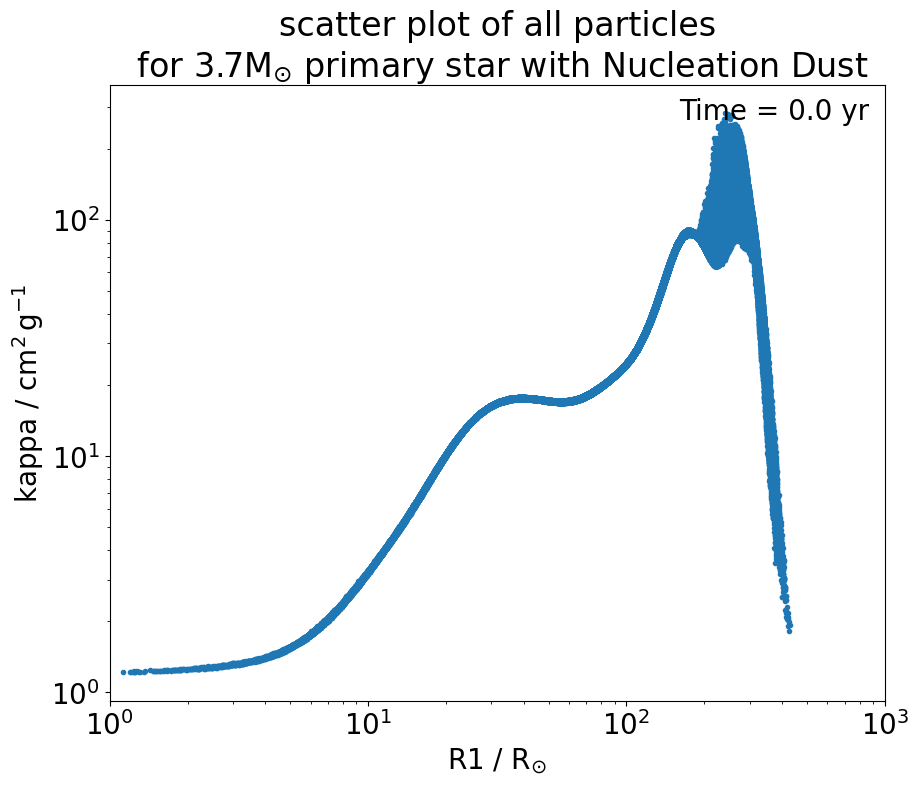

In [136]:
fig, ax = plot_stuff(stuff, 'R1', 'kappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

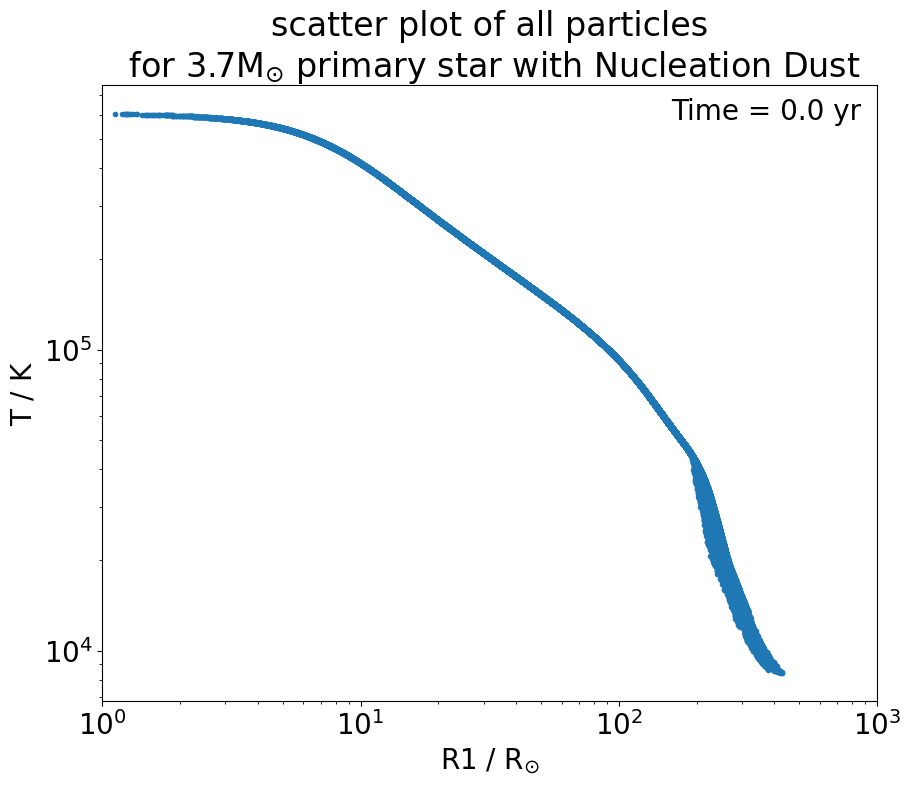

In [137]:
fig, ax = plot_stuff(stuff, 'R1', 'T', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

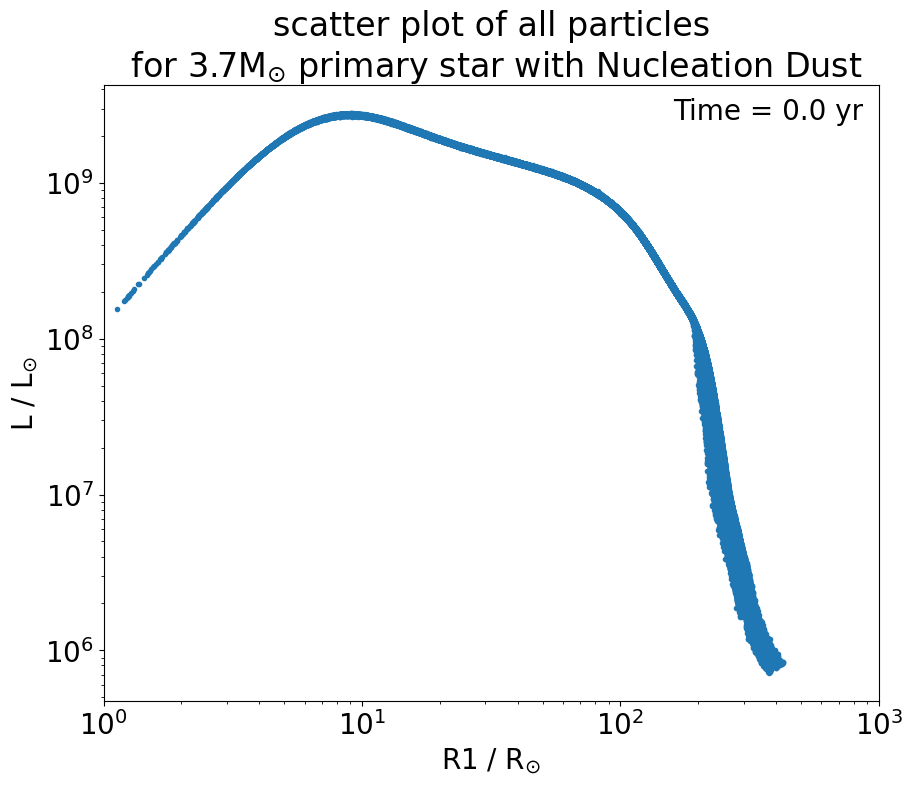

In [179]:
fig, ax = plot_stuff(stuff, 'R1', 'L', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Cross-Section at z = 0.0\nresolution = 1.37e+06'}, xlabel='x', ylabel='y'>)

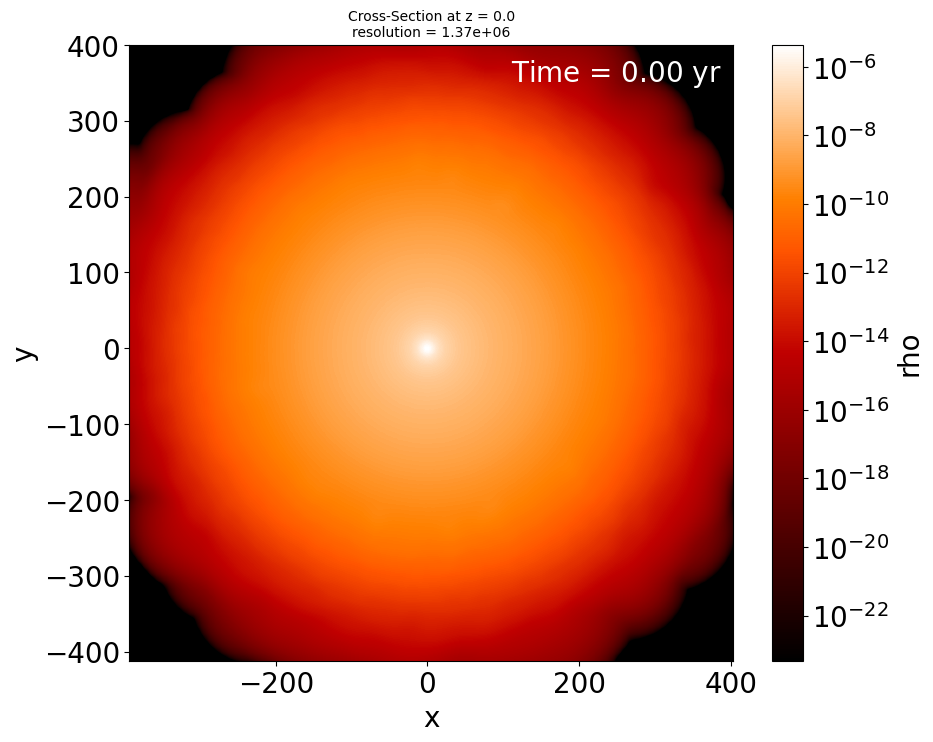

In [64]:
mpdf.plot_render()

In [76]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17), frac_contained=99.99)
rays

array([[[-377.92692617, -384.18817369,    0.        ],
        [-377.92692617, -384.18817369,    1.        ]],

       [[-330.6860604 , -384.18817369,    0.        ],
        [-330.6860604 , -384.18817369,    1.        ]],

       [[-283.44519463, -384.18817369,    0.        ],
        [-283.44519463, -384.18817369,    1.        ]],

       ...,

       [[ 283.44519463,  384.18817369,    0.        ],
        [ 283.44519463,  384.18817369,    1.        ]],

       [[ 330.6860604 ,  384.18817369,    0.        ],
        [ 330.6860604 ,  384.18817369,    1.        ]],

       [[ 377.92692617,  384.18817369,    0.        ],
        [ 377.92692617,  384.18817369,    1.        ]]])

In [86]:
no_xy=(17, 17)
rays, areas = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=99.99)
lums = []
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lums.append(dat * area) #* 4 * pi 
    if len(lums)%10 == 0:
        print(len(lums))

lums = (lums * mpdf.units['lum']).to(units.solLum)
lum = lums.sum()
lum

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


<Quantity 273543.11736144 solLum>

In [267]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity)
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T'] * sdf['T']**4 #/ (4 * pi)

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([9.36841334e-13 3.02453466e-14 2.47169186e-14])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 0.00000000e+00  3.59257537e-16 -1.80945419e-16]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


In [242]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17))
lum = 0.
lums = []
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi
    lums.append(dat*area)
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)/1e6

0
50
100
150
200
250


<Quantity 441.35704836 solLum>

In [270]:
sdf['R0'] = (sdf['x']**2 + sdf['y']**2 + sdf['z']**2)**0.5
sdf['kappa_cgs'] = mupl.units_util.get_val_in_unit(sdf['kappa'], mpdf.units['opacity'], units.cm**2/units.g)
sdf.iloc[np.array(sdf['R0'] > 380)]

iorig           x           y           z   temperature     gamma  \
111          112 -333.503997 -196.819580  -58.476116   9564.784823  1.666667   
438          439 -345.411224  -39.160593  234.792402   6615.074278  1.666667   
529          530 -440.836939   43.341735   14.205282   8963.335961  1.666667   
906          907 -395.633312  -80.204010   59.915316   9112.569457  1.666667   
1146        1147 -326.235900 -227.981242  124.129664   8781.755459  1.666667   
...          ...         ...         ...         ...           ...       ...   
1370136  1370137 -343.056122  176.931071  -58.063187   9766.805514  1.666667   
1370938  1370939 -397.871879    7.405970 -112.754290   9627.812530  1.666667   
1371122  1371123 -387.733425   41.448333   -4.518698  10750.967039  1.666667   
1371170  1371171 -294.004232 -242.893745 -147.497417   6726.268402  1.666667   
1372058  1372059 -345.796117 -145.778940  -64.733002  10791.660293  1.666667   

               vx        vy        vz         u  ...      divv         poten  \
111      0.002022 -0.018438 -0.002364  0.003201  ... -0.000093 -1.693614e-09   
438     -0.002858 -0.019164  0.003671  0.001280  ...  0.000110 -1.521432e-09   
529     -0.005641 -0.020930  0.005006  0.002863  ...  0.000056 -1.577284e-09   
906      0.007254 -0.013098 -0.003132  0.002439  ... -0.000450 -1.747112e-09   
1146    -0.001352 -0.030919  0.006285  0.003117  ...  0.000229 -1.493005e-09   
...           ...       ...       ...       ...  ...       ...           ...   
1370136 -0.002968 -0.013376 -0.003774  0.003291  ...  0.000198 -1.737399e-09   
1370938  0.006797 -0.021440 -0.003923  0.003228  ... -0.000230 -1.703030e-09   
1371122 -0.004583 -0.015976 -0.002957  0.003920  ...  0.000020 -1.910990e-09   
1371170  0.002479 -0.022371 -0.000131  0.001310  ...  0.000036 -1.485059e-09   
1372058 -0.004315 -0.023571 -0.004763  0.004344  ...  0.000228 -1.837619e-09   

                    m           rho         v        vr             T  \
111      8.321285e-07  2.614854e-10  0.018698  0.007897   9564.784823   
438      8.321285e-07  7.494553e-11  0.019720  0.006197   6615.074278   
529      8.321285e-07  1.240719e-10  0.022248  0.003725   8963.335961   
906      8.321285e-07  3.430497e-10  0.015297 -0.004918   9112.569457   
1146     8.321285e-07  6.204438e-11  0.031580  0.019836   8781.755459   
...               ...           ...       ...       ...           ...   
1370136  8.321285e-07  3.301369e-10  0.014211 -0.002893   9766.805514   
1370938  8.321285e-07  2.787013e-10  0.022831 -0.005853   9627.812530   
1371122  8.321285e-07  8.187017e-10  0.016882  0.002893  10750.967039   
1371170  8.321285e-07  6.082245e-11  0.022508  0.011554   6726.268402   
1372058  8.321285e-07  5.751094e-10  0.024431  0.013751  10791.660293   

         kappa_dust          R0  kappa_cgs  
111             0.0  391.640549  14.434284  
438             0.0  419.487709   0.090066  
529             0.0  443.190143   6.143182  
906             0.0  408.103230   9.463218  
1146            0.0  416.909441   4.060100  
...             ...         ...        ...  
1370136         0.0  390.337598  18.601888  
1370938         0.0  413.606589  15.574132  
1371122         0.0  389.968706  51.144606  
1371170         0.0  408.890386   0.107749  
1372058         0.0  380.810734  44.347211  

[5382 rows x 33 columns]

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Cross-Section at z = 0.0\nresolution = 1.37e+06'}, xlabel='x', ylabel='y'>)

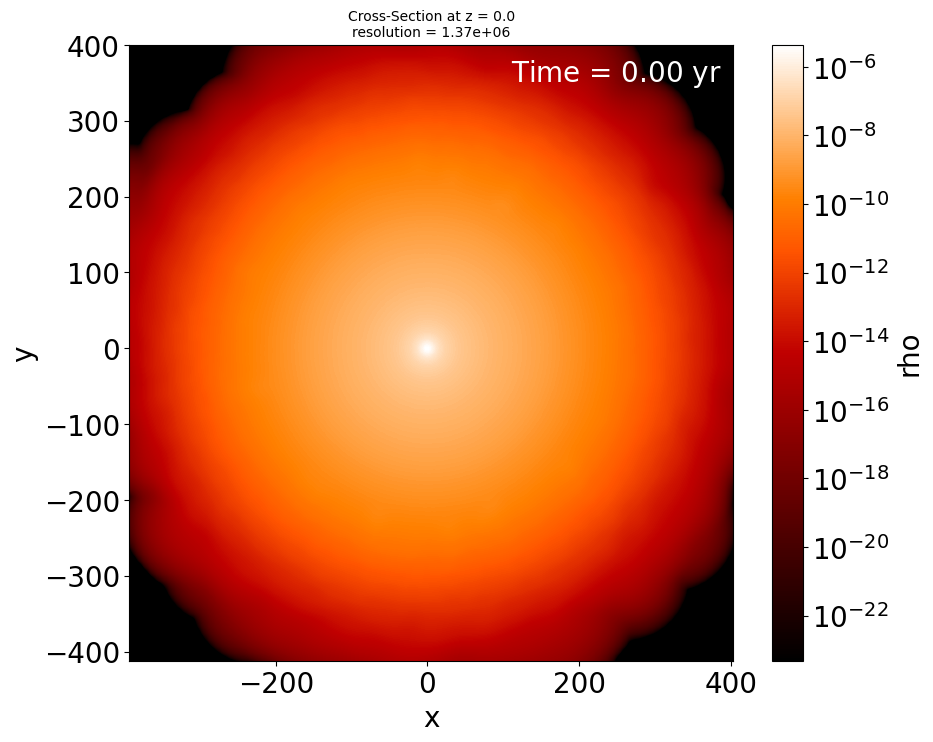

In [57]:
mpdf.plot_render()

In [244]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(16, 16))
lum = 0.
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi 
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)

0
50
100
150
200
250


<Quantity 4.43158595e+08 solLum>

In [37]:
ans = integrate_along_ray(sdf, ray, srcfuncs)
pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
dat

backward dat =  1.1572865300327659e-15
	Contribution to L from photosphere and outwards is: 31.877263611212765 %
	50% Contributed correspond to tau = 1.6343815396229042
forward dat =  1.157286530032766e-15


1.157286530032766e-15

In [43]:

np.where(dat_bwd_inc / dat > 1e-7), dat_bwd_inc.shape

((array([  0,   1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  15,
          16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
          55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
          68,  69,  70,  71,  73,  74,  75,  77,  81,  82,  85, 308, 314,
         315, 319, 320, 322, 326, 329, 334, 335, 336, 338, 342, 343, 344,
         346, 348, 349, 350, 353, 354, 355, 356, 359, 363, 364, 365, 367,
         368, 369, 371, 373, 374, 375, 377, 381, 382, 383, 385, 387, 389,
         394, 396, 400, 401, 402, 403, 404, 405, 406, 408, 410, 412, 414,
         424, 429]),),
 (4694,))

In [7]:
def get_ph_vals(
    vals_names: list,
    mpdf: MyPhantomDataFrames,
    eos: mupl.eos_base.EoS_Base,
    rays_unit_vecs : np.ndarray, # (no_ray, 3)-shaped
    verbose: int,
):
    sdf_all = mpdf.data['gas']
    hs = np.array(sdf_all['h'])
    pts = np.array(sdf_all[['x', 'y', 'z']])    # (npart, 3)-shaped array
    kernel_radius = sdf_all.kernel.get_radius()

    plane_orig_vec = np.array(mpdf.data['sink'][['x', 'y', 'z']].iloc[0])

    # random direction in the sphere
    #rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
    no_ray = len(rays_unit_vecs)
    
    vals_dict = {
        'tau_dust': np.full(no_ray, np.nan),
        'inner_dust_shell_rad': np.full(no_ray, np.nan) * mpdf.units['dist'],
    }
    
    for iray, ray_unit_vec in enumerate(rays_unit_vecs):
        ray = np.array([
            plane_orig_vec,
            plane_orig_vec + ray_unit_vec,
        ])
        
        pts_on_ray = mupl.get_closest_pt_on_line(pts, ray)
        sdf_selected_indices = (np.sum((pts - pts_on_ray)**2, axis=-1) <= (kernel_radius * hs)**2)
        sdf = sdf_all.iloc[sdf_selected_indices]
        
        pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf, ray)
        photosphere, waypts_list = get_photosphere_on_ray(
            pts_on_ray, dtaus, pts_order, sdf, ray,
            calc_params = vals_names,
            eos = eos,
            sdf_units = mpdf.units,
            photosphere_tau = PHOTOSPHERE_TAU,
            return_as_quantity=True,
            verbose = 1 if is_verbose(verbose, 'err') else 0,
        )
        for val_name in vals_names:
            if iray == 0:
                # init
                vals_dict[val_name] = np.full((*photosphere[val_name].shape, no_ray), np.nan)
                if isinstance(photosphere[val_name], units.quantity.Quantity):
                    vals_dict[val_name] *= photosphere[val_name].unit
            # save value
            vals_dict[val_name][iray] = photosphere[val_name]
            
            kappa_tol = 1e-7*(units.cm**2/units.g)
            kappa_tol_val = kappa_tol.to_value(mpdf.units['opacity'])
            pts_waypts_t = np.sum((pts_on_ray - ray[0]) * ray_unit_vec, axis=-1) # the higher, the more on the pt2 side (observer)
            # find the furtherest dust-containing particle on the observer's side
            last_dust_part_ordered_indices = np.where(np.logical_and(
                pts_waypts_t[pts_order] > 0,    # condition 1: on the observer's side (i.e. don't be further than the sink)
                sdf.iloc[pts_order]['kappa_dust'] > kappa_tol_val,    # condition 2: dust-containing
            ))[0]
            if len(last_dust_part_ordered_indices):
                # found the dust shell!
                last_dust_part_ordered_ind = last_dust_part_ordered_indices[-1]
                vals_dict['tau_dust'][iray] = np.sum(dtaus[pts_order][:last_dust_part_ordered_ind])
                vals_dict['inner_dust_shell_rad'][iray] = mupl.set_as_quantity(
                    pts_waypts_t[pts_order][last_dust_part_ordered_ind], mpdf.units['dist'])
    vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
    vals_dict['ray_unit_vec'] = rays_unit_vecs
    
    return vals_dict

In [8]:
def get_photosphere_vals_rand_samples(
    job_nickname: str,
    file_index: int,
    no_ray: int,
    vals_names: list = ['R1', 'T'],
    cos_theta_sample_no: int|None = None,
    mpdf: MyPhantomDataFrames = None,
    verbose: int = 3,
) -> dict:
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos = job_profile['ieos']
    eos  = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    mpdf = mpdf_read(
        job_name, file_index, eos_opacity, mpdf,
        kappa_gas = 2e-4*(units.cm**2/units.g) if file_index != 0 else 0.*(units.cm**2/units.g),
        verbose=verbose)

    if cos_theta_sample_no is None:

        rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
        vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
    
        if is_verbose(verbose, 'note'):
            say('note', f'{mpdf.get_filename()}', verbose,
                *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
            )
    else:
        # A fixed amount of rays per cos_theta interval will be generated
        #cos_theta_sample_no = 2
        ray_per_cos_theta = int(no_ray/cos_theta_sample_no)
        cos_theta_delta = 1. / cos_theta_sample_no
        cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)
        vals_by_cos_thetas = []
    
        for i, cos_theta_mid in enumerate(cos_thetas):
            rays_unit_vecs = get_rand_rays_unit_vec(ray_per_cos_theta, cos_theta_mid, cos_theta_delta)
            vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
            #vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
            vals_by_cos_thetas.append(vals_dict)
        
            if is_verbose(verbose, 'note'):
                say('note', f'cos_theta_mid = {cos_theta_mid}', verbose,
                    *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
                )
        
        vals_dict = { key: np.concatenate([data[key] for data in vals_by_cos_thetas]) for key in vals_by_cos_thetas[0].keys()}

    return vals_dict

.

## Main

.


In [10]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    for job_nickname in ['2md']:  # '2md', 
        for file_index in [4800, 6400]: # [0, 2000, 8000, 17600]
            vals_dict = get_photosphere_vals_rand_samples(
                job_nickname, file_index, no_ray, vals_names=['R1', 'T', 'rho', 'kappa', 'nneigh', 'vr'], cos_theta_sample_no=None, mpdf=mpdf)
            with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'w') as f:
                json_dump(vals_dict, f, metadata)
    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_04800'


*   Note   :    MyPhantomDataFrames.read():
	CoM significantly deviates from the origin with distance of 3.720647492094738.
	Consider use reset_xyz_by_CoM=True option when read?
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
91705 1356310
*   Note   :    ../photosphere/luis_2md/light_04800:
	R1 = 27094.61603459788 udist +/- 1954.4331316030925 udist
	T = 513.0249707436063 K +/- 50.96035232156766 K
	rho = 1.7947891556866646e-16 umass / udist3 +/- 4.520868390693096e-17 umass / udist3
	kappa = 2554526279067.905 